# Проект на курсе Machine Learning Бакалавриат
### Тема проекта: Предсказание цен на акции российской биржи с учётом новостного потока
### Состав команды: Ступников Дмитрий, Клюшова Ульяна, Садоян Давид, Савин Владислав
### Задача проекта: научиться предсказывать на k <= 30 дней вперёд цены на акции МосБиржи, учитывая новостной поток

### Описание данных:


Датасет 1 (candle) - Ценовые данные (OHLCV): open, high, low, close, volume с 19.06.2020 до 08.09.2025 по 19 тикерам с МосБиржи. Это соответственно начальная, максимальная, минимальная, конечная цена и объём за каждый из торгуемых дней


Датасет 2 (news) - Новостные данные с портала finam.ru - крупнейшего российского брокера (у них мы и позаимствовали данный датасет): дата публикации, заголовок, текст


In [2]:
!pip install transformers torch tqdm bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 34.2 MB/s eta 0:00:00:00:0100:01
  Attempting un

In [3]:
import pandas as pd
import gdown
import matplotlib.pyplot as plt
import seaborn as sns

## EDA Датасета candle
Изначально датасет был разделён на до 2025 и после 2025, как на train и test, мы его соединяем и дальше уже будем работать

In [4]:
url_candles = 'https://drive.google.com/file/d/12n1JmpNTDgNpRVuv9oF1MwsyNZQELTmi/view?usp=share_link'
url_candles_2 = 'https://drive.google.com/file/d/1BN5NCtZ3k6NUuvX2M1xAiZZ91vDGc2BH/view?usp=share_link'

file_id_train = url_candles.split('/')[-2]
local_file_path_train = 'df_candles.csv'
gdown.download(id=file_id_train, output=local_file_path_train, quiet=False)

file_id_test = url_candles_2.split('/')[-2]
local_file_path_test = 'df_candles_2.csv'
gdown.download(id=file_id_test, output=local_file_path_test, quiet=False)

df_candels = pd.read_csv(local_file_path_train)
df_candels_2 = pd.read_csv(local_file_path_test)

print(f"размерность датасета до 2025 года: {df_candels.shape}")
print(f"размерность датасета  2025 года: {df_candels_2.shape}")

Downloading...
From: https://drive.google.com/uc?id=12n1JmpNTDgNpRVuv9oF1MwsyNZQELTmi
To: /kaggle/working/df_candles.csv
100%|██████████| 1.25M/1.25M [00:00<00:00, 2.78MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BN5NCtZ3k6NUuvX2M1xAiZZ91vDGc2BH
To: /kaggle/working/df_candles_2.csv
100%|██████████| 89.0k/89.0k [00:00<00:00, 712kB/s]

размерность датасета до 2025 года: (24197, 7)
размерность датасета  2025 года: (1745, 7)


In [5]:
df = pd.concat([df_candels, df_candels_2], ignore_index=True)
print("Общий датасет:", df.shape)


Общий датасет: (25942, 7)


In [6]:
display(df.head())
df.info()
df.describe()


,open,close,high,low,volume,begin,ticker
0,81.50,81.70,83.20,81.16,29755530,2020-06-19,AFLT
1,81.72,82.10,83.98,80.26,18502950,2020-06-22,AFLT
2,82.04,81.20,82.48,80.40,16848930,2020-06-23,AFLT
3,79.78,80.58,80.80,78.22,21559860,2020-06-25,AFLT
4,80.50,79.38,81.44,78.76,14677280,2020-06-26,AFLT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25942 entries, 0 to 25941
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    25942 non-null  float64
 1   close   25942 non-null  float64
 2   high    25942 non-null  float64
 3   low     25942 non-null  float64
 4   volume  25942 non-null  int64  
 5   begin   25942 non-null  object 
 6   ticker  25942 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.4+ MB


,open,close,high,low,volume
count,25942.000000,25942.000000,25942.000000,25942.000000,2.594200e+04
mean,1400.465847,1399.723822,1418.708326,1379.193781,3.154513e+09
std,2093.777230,2092.542764,2119.684280,2063.558303,2.280749e+10
min,21.900000,22.440000,23.280000,21.440000,1.246000e+03
25%,113.800000,113.800000,115.378750,112.142500,5.113432e+05
50%,310.975000,310.970000,313.970000,308.695000,2.900915e+06
75%,1481.150000,1481.425000,1503.537500,1457.875000,1.767637e+07
max,9000.000000,8908.000000,10097.000000,8500.000000,7.032681e+11


In [7]:
df["begin"] = pd.to_datetime(df["begin"])

In [ ]:
missing = df.isnull().sum()
print(missing)

open      0
close     0
high      0
low       0
volume    0
begin     0
ticker    0
dtype: int64


кайф)

In [ ]:
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
25937,False
25938,False
25939,False
25940,False


In [ ]:
print(df.duplicated().sum())
df = df.drop_duplicates()


321


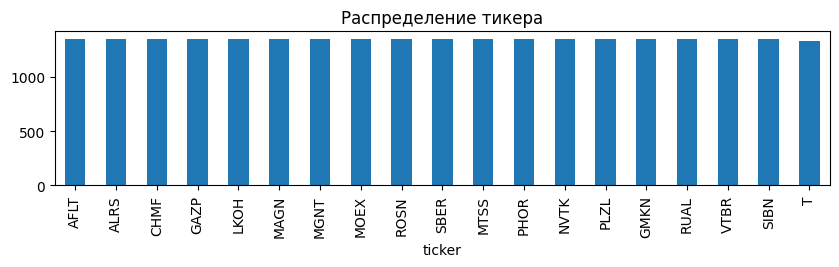

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(10,2))
    df[col].value_counts().plot.bar()
    plt.title(f"Распределение тикера")
    plt.show()


сделаем анализ временного ряда для каждого тикера

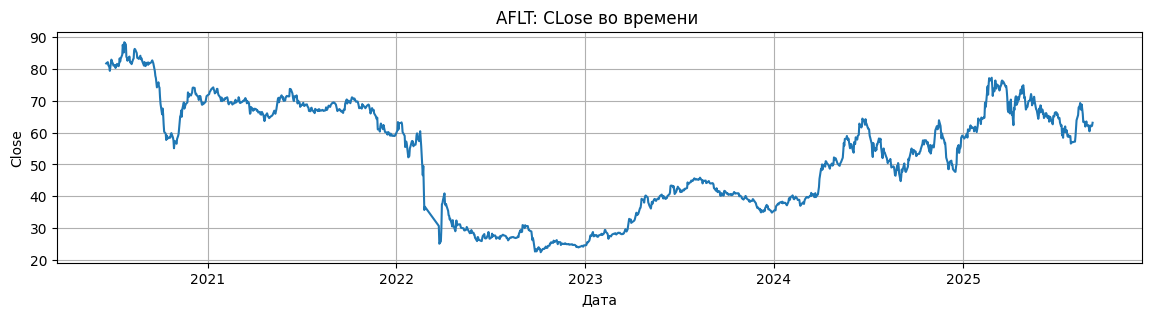

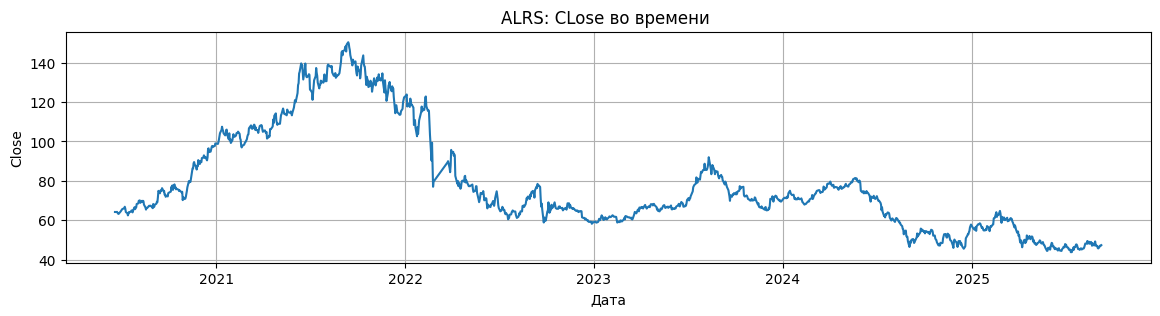

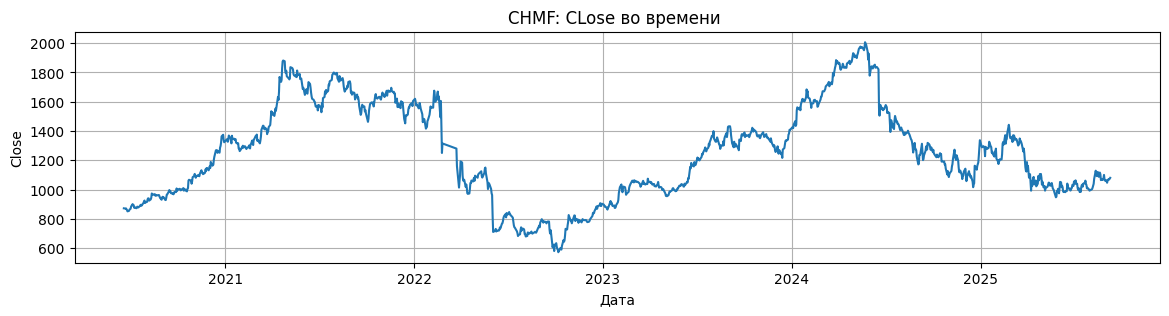

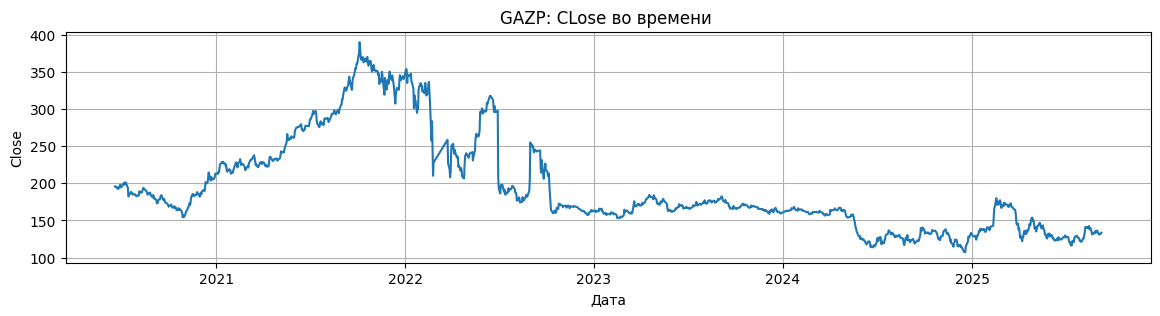

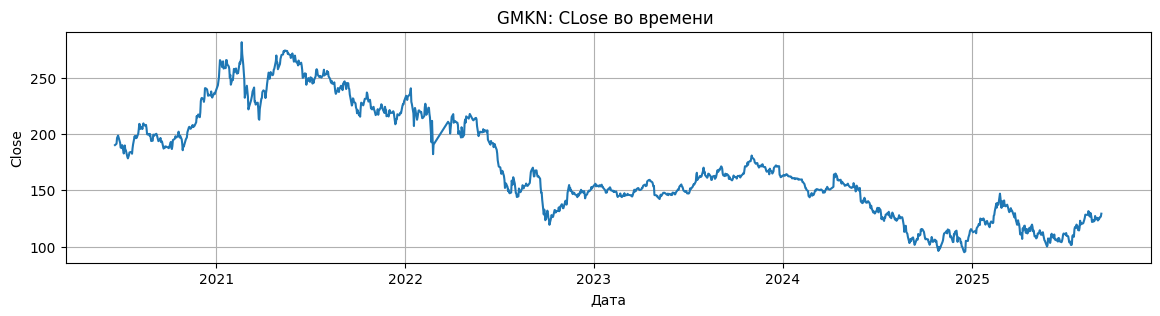

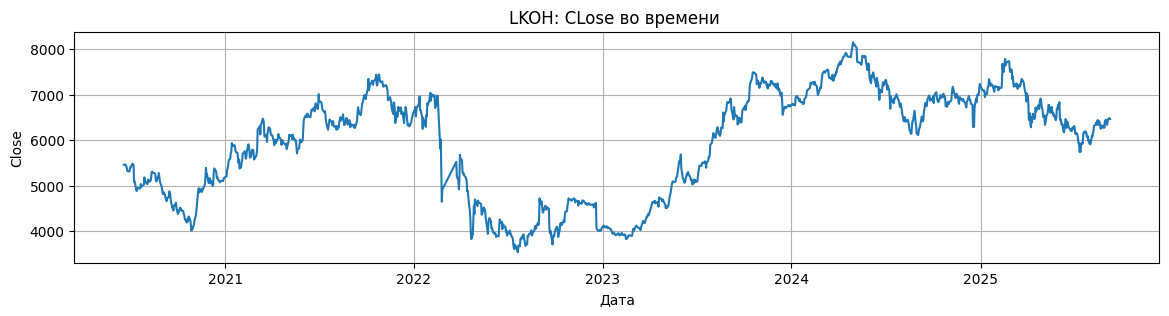

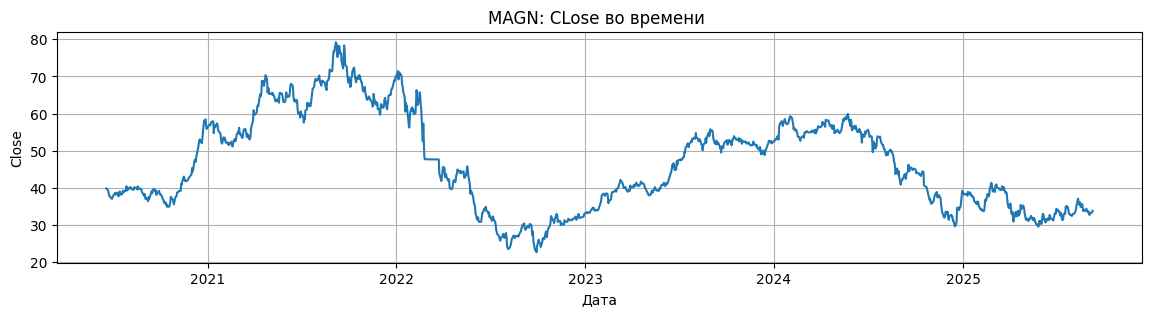

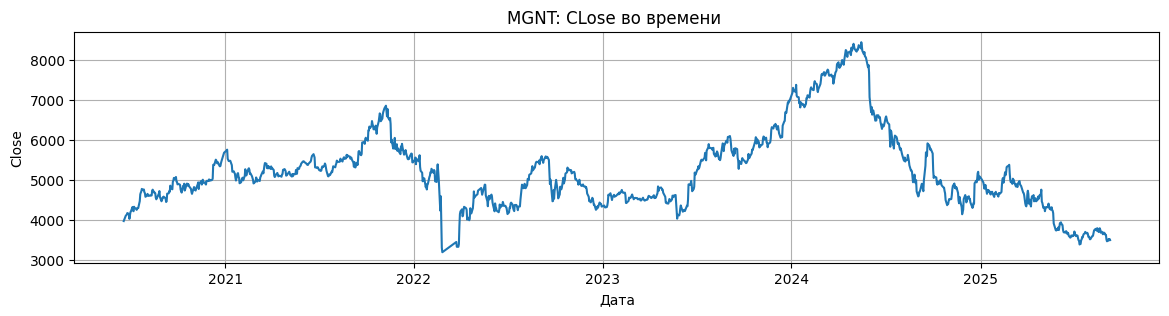

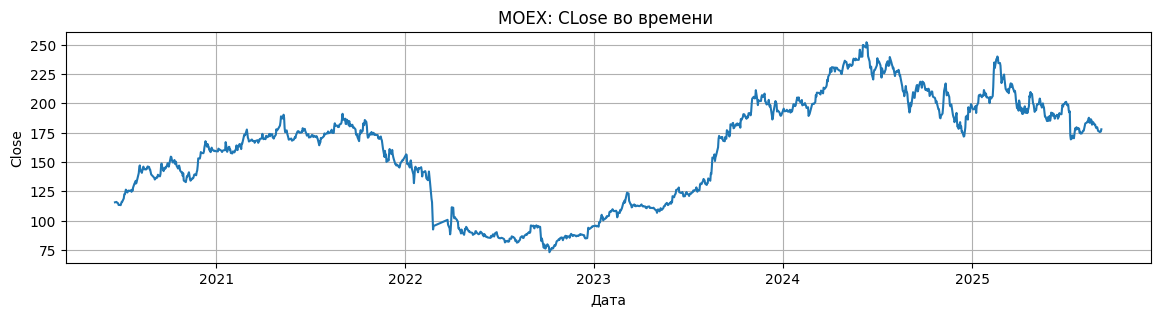

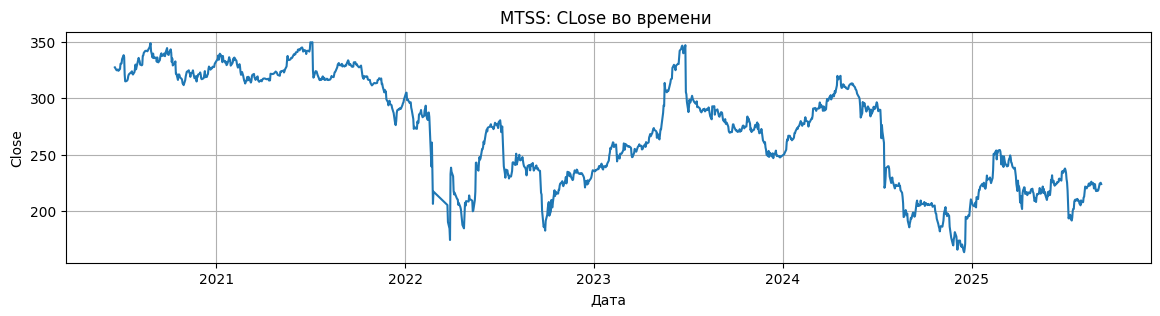

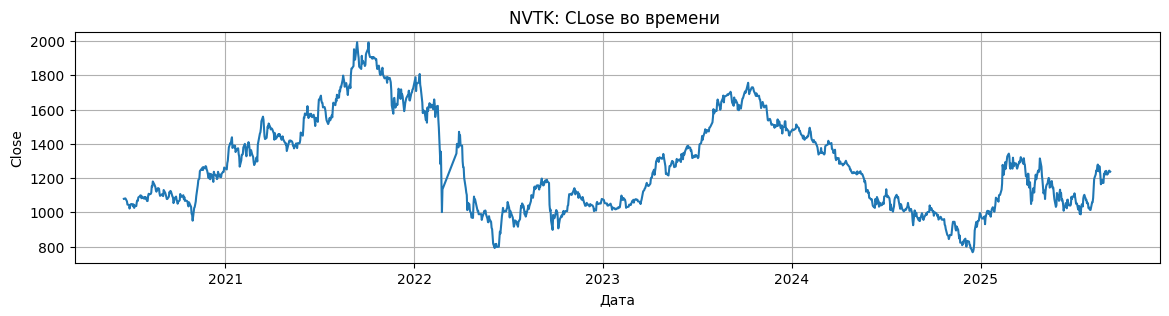

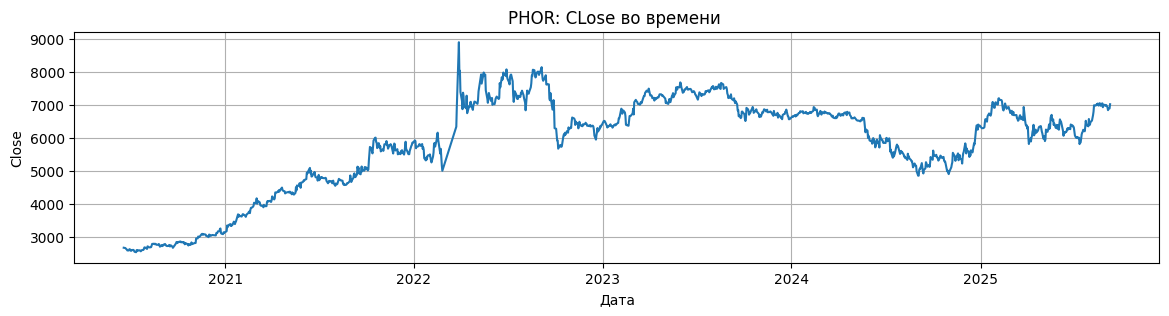

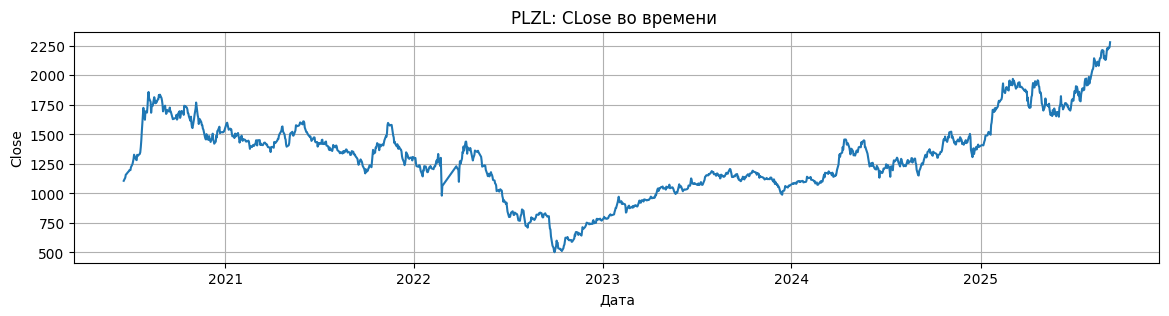

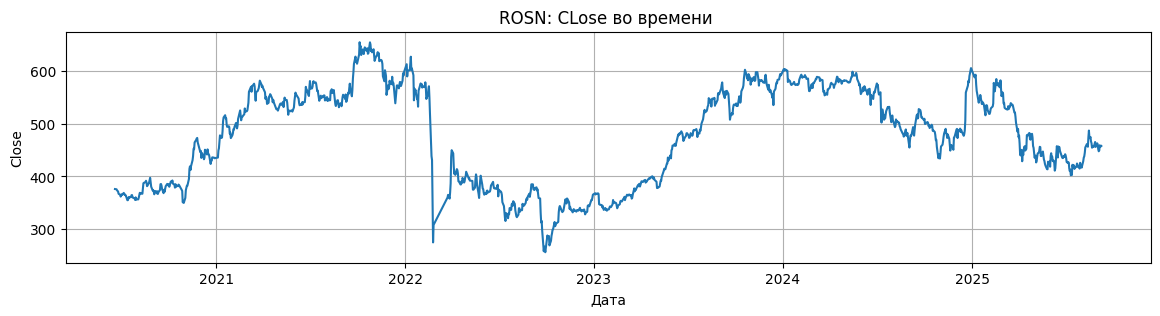

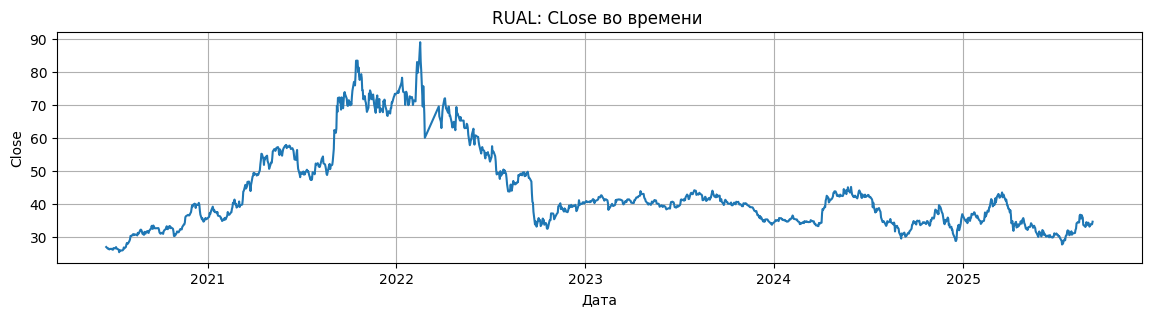

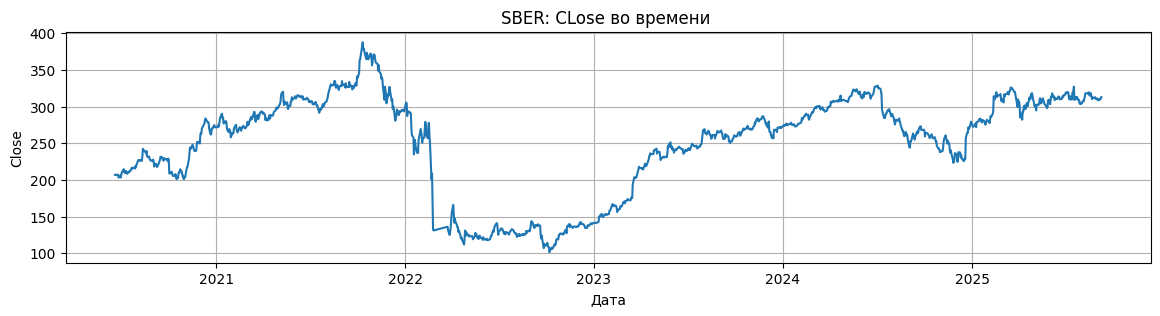

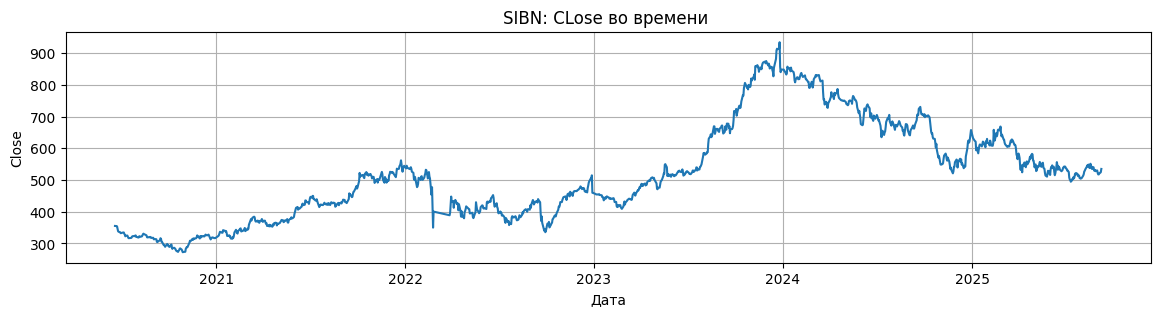

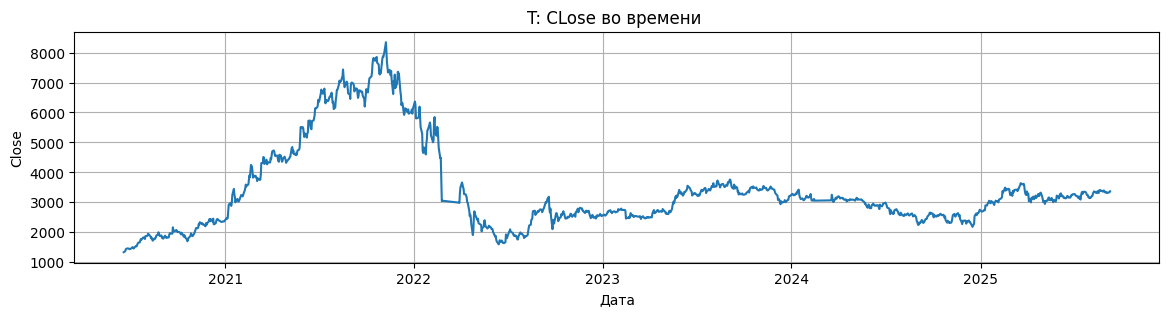

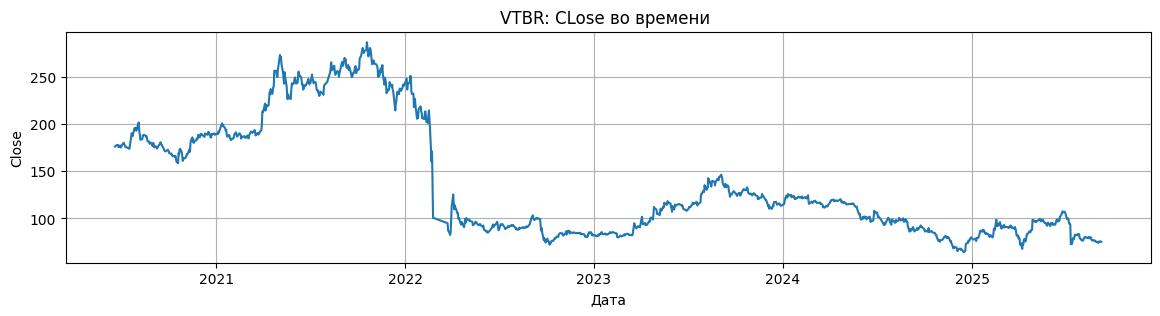

In [ ]:
for ticker in df['ticker'].unique():
    plt.figure(figsize=(14,3))
    df_tic = df[df['ticker'] == ticker].sort_values('begin')
    plt.plot(df_tic['begin'], df_tic['close'])
    plt.title(f'{ticker}: CLose во времени ')
    plt.xlabel("Дата")
    plt.ylabel("Close")
    plt.grid()
    plt.show()


имеются аномалии а также разрывы (мы сами их каким-то образом сделали, хз как, я тут часть поудалял, теперь разрывов нет)

посмотрим на суточные доходы

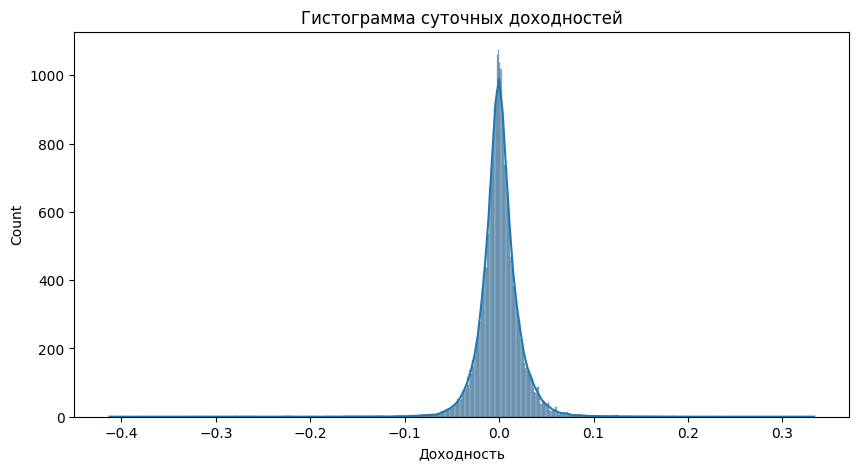

In [ ]:
df = df.sort_values(['ticker', 'begin'])
df['return'] = df.groupby('ticker')['close'].pct_change()

plt.figure(figsize=(10,5))
sns.histplot(df['return'].dropna(), kde=True)
plt.title('Гистограмма суточных доходностей')
plt.xlabel('Доходность')
plt.show()


вроде как нормальное распределение) уже хорошо

In [ ]:
df['return'].describe()

,return
count,25602.000000
mean,0.000336
std,0.022487
min,-0.412538
25%,-0.009538
50%,0.000000
75%,0.009914
max,0.333715


хотя тут есть хвост побольше в отрицательную сторону

У нас еще доходность от обьема

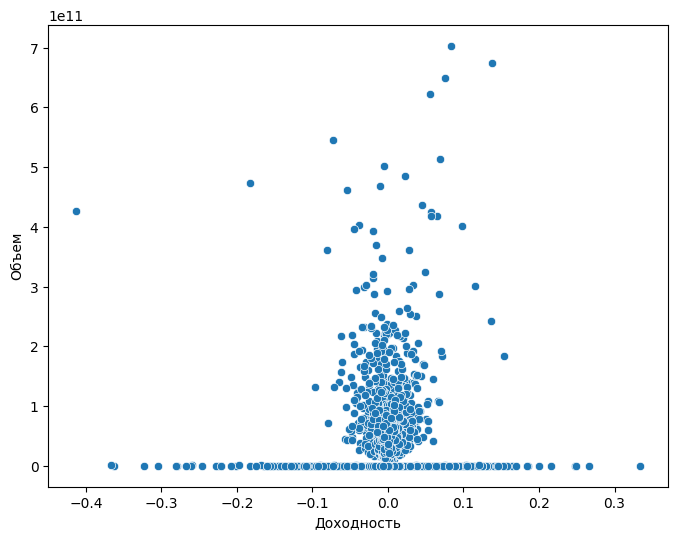

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='return', y='volume', data=df)
plt.xlabel('Доходность')
plt.ylabel('Объем')
plt.show()


ну да в целом хвост возник из за маленьких обьемов. Так что некритично

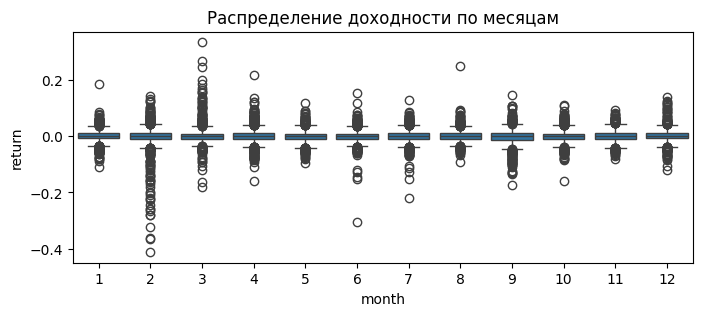

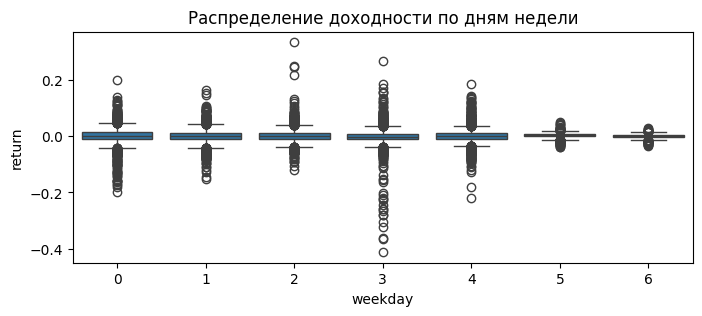

In [ ]:
df['month'] = df['begin'].dt.month
df['weekday'] = df['begin'].dt.weekday
plt.figure(figsize=(8,3))
sns.boxplot(x='month', y='return', data=df)
plt.title('Распределение доходности по месяцам')
plt.show()

plt.figure(figsize=(8,3))
sns.boxplot(x='weekday', y='return', data=df)
plt.title('Распределение доходности по дням недели')
plt.show()


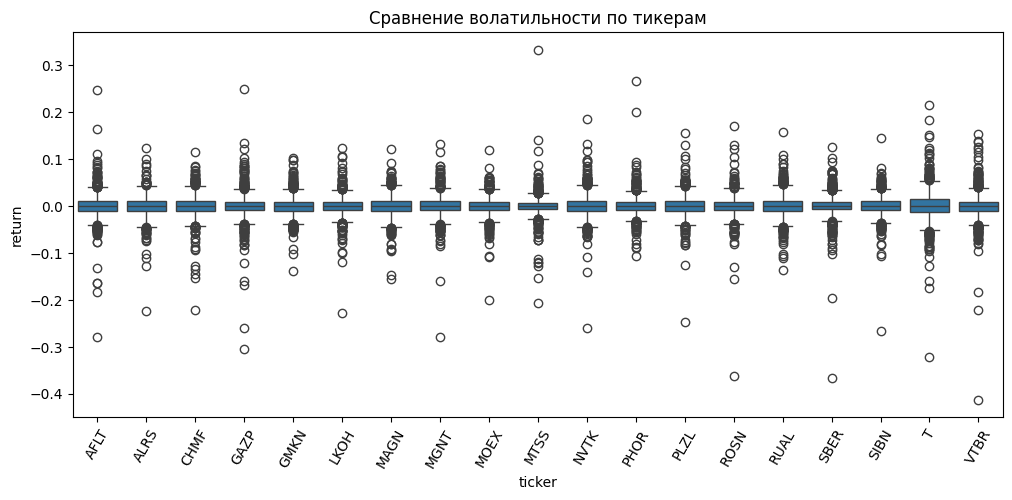

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(x='ticker', y='return', data=df)
plt.title('Сравнение волатильности по тикерам')
plt.xticks(rotation=60)
plt.show()


неудивительно что T один из самых волотильных

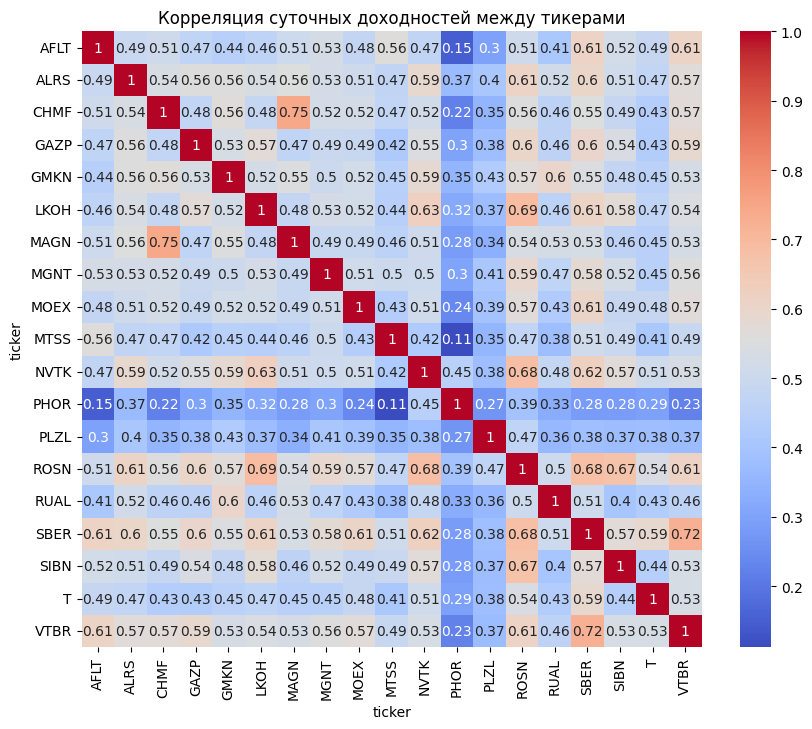

In [ ]:
df_for_pivot = df.groupby(['begin', 'ticker'])['return'].mean().reset_index()
returns = df_for_pivot.pivot(index='begin', columns='ticker', values='return')
plt.figure(figsize=(10,8))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция суточных доходностей между тикерами')
plt.show()

как видим у нас большинство тикеров между собой очень хорошо коррелируют. Бывают и суперкоррелированные. Допустим CHMF и MAGN

In [ ]:
anom = df[df['return'].abs() > 0.2]
print(anom[['begin','ticker','open','close','return']])
print(f"дней когда движение было бошльше 20%  {len(anom)}")


           begin ticker     open    close    return
427   2022-02-24   AFLT    44.50    35.70 -0.279079
433   2022-03-30   AFLT    31.14    37.54  0.247176
1703  2022-02-24   ALRS    89.97    77.01 -0.224471
2979  2022-02-24   CHMF  1490.00  1250.00 -0.221087
4255  2022-02-24   GAZP   255.02   210.00 -0.259285
4322  2022-06-30   GAZP   299.50   207.00 -0.304552
4366  2022-08-31   GAZP   224.40   254.90  0.249510
6803  2022-02-24   LKOH  5410.50  4650.00 -0.227575
9355  2022-02-24   MGNT  4140.00  3312.00 -0.280000
10631 2022-02-24   MOEX   104.15    92.54 -0.200795
11907 2022-02-24   MTSS   235.00   206.65 -0.207782
11913 2022-03-30   MTSS   177.15   233.00  0.333715
13183 2022-02-24   NVTK  1209.40  1001.40 -0.260414
14459 2022-03-24   PHOR  5483.00  6350.00  0.266201
14461 2022-03-28   PHOR  7000.00  8345.00  0.200547
15731 2022-02-24   PLZL  1271.15   981.00 -0.246196
17004 2022-02-24   ROSN   388.35   274.70 -0.363088
19552 2022-02-24   SBER   187.54   132.18 -0.366134
20828 2022-0

## EDA Датасета news

In [8]:
url_news_1 = 'https://drive.google.com/file/d/1JRzL3OormLhHI1S7JwhudLoZKKs_59sB/view?usp=share_link'
url_news_2 = 'https://drive.google.com/file/d/1bHHMh7HqjG0R9EHhgc-dYanizVmrCvj8/view?usp=share_link'

file_id_train = url_news_1.split('/')[-2]
local_file_path_train = 'df_news_1.csv'
gdown.download(id=file_id_train, output=local_file_path_train, quiet=False)

file_id_test = url_news_2.split('/')[-2]
local_file_path_test = 'df_news_2.csv'
gdown.download(id=file_id_test, output=local_file_path_test, quiet=False)

df_news_1 = pd.read_csv(local_file_path_train, index_col=0)
df_news_2 = pd.read_csv(local_file_path_test, index_col=0)

print(f"размерность датасета до 2025 года: {df_news_1.shape}")
print(f"размерность датасета  2025 года: {df_news_2.shape}")

Downloading...
From: https://drive.google.com/uc?id=1JRzL3OormLhHI1S7JwhudLoZKKs_59sB
To: /kaggle/working/df_news_1.csv
100%|██████████| 92.1M/92.1M [00:06<00:00, 15.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bHHMh7HqjG0R9EHhgc-dYanizVmrCvj8
To: /kaggle/working/df_news_2.csv
100%|██████████| 8.73M/8.73M [00:00<00:00, 11.9MB/s]


размерность датасета до 2025 года: (25425, 3)
размерность датасета  2025 года: (2030, 2)


In [9]:
df_news = pd.concat([df_news_1, df_news_2], ignore_index=True)
print("Общий датасет:", df_news.shape)

Общий датасет: (27455, 3)


In [10]:
df_news.head()

,publish_date,title,publication
0,2020-01-01 14:00:00,Ключевые российские нефтегазовые компании смот...,Тенденции в отрасли. Ключевые российские нефте...
1,2020-01-02 15:00:00,ММК выгодно отличает высокая экспозиция на вну...,Тенденции в отрасли. Ключевые российские стале...
2,2020-01-03 10:13:10,Контракты на поставку газа в Белоруссию и тран...,"Председатель правления ""Газпрома"" Алексей Милл..."
3,2020-01-03 13:26:29,"ПАО ""ФосАгро"" -Внеочередное общее собрание",Дата и время ВОСА – 24.01.2020 23:59:59 Дата ...
4,2020-01-03 13:44:03,"ПАО ""ММК"" - Внеочередное общее собрание- ИТОГИ",Дата и время собрания - 27.12.2019 00:00:00 Д...


Мы будем использовать локальную LLM модель - Qwen 2.5-3B-Instruct, чтобы определить по какой компании данная новость, затем чтобы определить тональность новости мы развернём специальную модель для финансовых новостей https://huggingface.co/mxlcw/rubert-tiny2-russian-financial-sentiment

In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [12]:
import numpy as np
from openai import AsyncOpenAI
import asyncio
from tqdm.asyncio import tqdm_asyncio
import time
from typing import List, Tuple

In [13]:
API_KEY = "sk-f1DtTUMgvdpDj18CK6aE7A"

MAX_CONCURRENT_REQUESTS = 200
REQUESTS_PER_MINUTE = 1000
BATCH_SIZE = 100
RETRY_ATTEMPTS = 3
RETRY_DELAY = 2

client = AsyncOpenAI(
    base_url="https://api.vsellm.ru/v1",
    api_key=API_KEY
)
semaphore = asyncio.Semaphore(MAX_CONCURRENT_REQUESTS)
class RateLimiter:
    def __init__(self, max_per_minute):
        self.max_per_minute = max_per_minute
        self.requests = []
    
    async def wait_if_needed(self):
        now = time.time()
        self.requests = [req_time for req_time in self.requests if now - req_time < 60]
        
        if len(self.requests) >= self.max_per_minute:
            sleep_time = 60 - (now - self.requests[0]) + 0.1
            if sleep_time > 0:
                await asyncio.sleep(sleep_time)
                self.requests = []
        
        self.requests.append(time.time())
rate_limiter = RateLimiter(REQUESTS_PER_MINUTE)
async def get_ticker_async(title: str, text: str, tickers_str: str, 
                          valid_tickers: list, attempt: int = 0) -> str:
    async with semaphore:
        await rate_limiter.wait_if_needed()
        
        system_prompt = (
            "You are an expert analyst of the Russian stock market with deep knowledge of publicly traded companies. "
            "Your task is to identify which company a news article primarily focuses on by selecting the correct ticker from a provided list. "
            "You must be precise and distinguish between primary subjects and secondary mentions."
        )
        
        user_prompt = f"""
Analyze the news article below and identify the PRIMARY company it discusses.

**Available tickers:** {tickers_str}

**NEWS ARTICLE:**
Title: "{title}"
Body: "{text}"

**ANALYSIS RULES:**
1. Identify the MAIN subject of the article - the company that is the primary focus
2. If multiple companies are mentioned, select the one that is the central topic
3. Ignore companies mentioned as examples, comparisons, or minor participants
4. If the news is about general market trends, macroeconomics, regulations, or doesn't specifically focus on any company from the list, return 'None'
5. If a company is mentioned through its subsidiaries, divisions, or projects, still return its ticker if it's in the list
6. News about mergers/acquisitions should return the ticker of the acquiring company or the main subject
7. Analyst recommendations, earnings reports, dividend announcements should return the ticker of the company being discussed

**EXAMPLES:**
Input: "Сбербанк увеличил чистую прибыль на 15% в первом квартале"
Output: SBER

Return ONLY the ticker symbol or 'None'. No explanations, no additional text, no punctuation.

**Your answer:**"""
        try:
            response = await client.chat.completions.create(
                model="openai/gpt-4o-mini",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0,
                max_tokens=10,
                timeout=30.0
            )
            
            ticker = response.choices[0].message.content.strip()
            ticker = ticker.replace('.', '').replace(',', '').upper()
            
            if ticker in valid_tickers or ticker == 'NONE':
                return ticker
            else:
                return 'None'
                
        except Exception as e:
            if attempt < RETRY_ATTEMPTS:
                await asyncio.sleep(RETRY_DELAY * (attempt + 1))
                return await get_ticker_async(title, text, tickers_str, 
                                             valid_tickers, attempt + 1)
            else:
                print(f"Ошибка после {RETRY_ATTEMPTS} попыток: {str(e)}")
                return 'None'

async def process_batch(batch_data: List[Tuple], tickers_str: str, 
                       valid_tickers: list) -> List[str]:
    tasks = []
    for idx, title, text in batch_data:
        task = get_ticker_async(title, text, tickers_str, valid_tickers)
        tasks.append(task)
    
    results = await tqdm_asyncio.gather(*tasks, desc=f"Обработка батча")
    return results

async def classify_news_async(news_df: pd.DataFrame, target_tickers: np.ndarray) -> pd.DataFrame:
    tickers_str = ", ".join(sorted(target_tickers))
    valid_tickers_list = list(target_tickers)
    
    batch_data = [
        (idx, row['title'], row['publication'])
        for idx, row in news_df.iterrows()
    ]
    all_results = []
    for i in range(0, len(batch_data), BATCH_SIZE):
        batch = batch_data[i:i + BATCH_SIZE]
        print(f"\nОбработка батча {i//BATCH_SIZE + 1}/{(len(batch_data)-1)//BATCH_SIZE + 1}")
        
        batch_results = await process_batch(batch, tickers_str, valid_tickers_list)
        all_results.extend(batch_results)
        
        if i + BATCH_SIZE < len(batch_data):
            await asyncio.sleep(1)
    
    news_df['ticker'] = all_results
    return news_df
def main(news_df: pd.DataFrame, df: pd.DataFrame):
    target_tickers = np.unique(df['ticker'])
    print(f"Найдено {len(target_tickers)} уникальных тикеров")
    print(f"Всего новостей для классификации: {len(news_df)}")
    print(f"Параметры обработки:")
    print(f"  - Максимум одновременных запросов: {MAX_CONCURRENT_REQUESTS}")
    print(f"  - Лимит запросов в минуту: {REQUESTS_PER_MINUTE}")
    print(f"  - Размер батча: {BATCH_SIZE}")
    print(f"  - Попыток при ошибке: {RETRY_ATTEMPTS}")
    start_time = time.time()
    result_df = asyncio.run(classify_news_async(news_df.copy(), target_tickers))
    elapsed_time = time.time() - start_time
    print(f"\n✓ Обработка завершена за {elapsed_time/60:.2f} минут")
    print(f"✓ Обработано {len(result_df)} новостей")
    print(f"✓ Классифицировано: {(result_df['ticker'] != 'None').sum()} новостей")
    print(f"✓ Не удалось классифицировать: {(result_df['ticker'] == 'None').sum()} новостей")
    
    return result_df

In [14]:
import nest_asyncio
nest_asyncio.apply()
df_news_classified= main(df_news, df_candels)

Найдено 19 уникальных тикеров
Всего новостей для классификации: 27455
Параметры обработки:
  - Максимум одновременных запросов: 200
  - Лимит запросов в минуту: 1000
  - Размер батча: 100
  - Попыток при ошибке: 3

Обработка батча 1/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.50it/s]



Обработка батча 2/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.26it/s]



Обработка батча 3/275


Обработка батча: 100%|██████████| 100/100 [00:08<00:00, 11.59it/s]



Обработка батча 4/275


Обработка батча: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]



Обработка батча 5/275


Обработка батча: 100%|██████████| 100/100 [00:20<00:00,  4.83it/s]



Обработка батча 6/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.82it/s]



Обработка батча 7/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.30it/s]



Обработка батча 8/275


Обработка батча: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]



Обработка батча 9/275


Обработка батча: 100%|██████████| 100/100 [00:22<00:00,  4.41it/s]



Обработка батча 10/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.61it/s]



Обработка батча 11/275


Обработка батча: 100%|██████████| 100/100 [00:08<00:00, 11.14it/s]



Обработка батча 12/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.94it/s]



Обработка батча 13/275


Обработка батча: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]



Обработка батча 14/275


Обработка батча: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]



Обработка батча 15/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]



Обработка батча 16/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.45it/s]



Обработка батча 17/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.35it/s]



Обработка батча 18/275


Обработка батча: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]



Обработка батча 19/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]



Обработка батча 20/275


Обработка батча: 100%|██████████| 100/100 [00:08<00:00, 11.16it/s]



Обработка батча 21/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.57it/s]



Обработка батча 22/275


Обработка батча: 100%|██████████| 100/100 [00:08<00:00, 11.58it/s]



Обработка батча 23/275


Обработка батча: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]



Обработка батча 24/275


Обработка батча: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]



Обработка батча 25/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 11.04it/s]



Обработка батча 26/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.73it/s]



Обработка батча 27/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.69it/s]



Обработка батча 28/275


Обработка батча: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]



Обработка батча 29/275


Обработка батча: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]



Обработка батча 30/275


Обработка батча: 100%|██████████| 100/100 [00:08<00:00, 11.44it/s]



Обработка батча 31/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.30it/s]



Обработка батча 32/275


Обработка батча: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]



Обработка батча 33/275


Обработка батча: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]



Обработка батча 34/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.65it/s]



Обработка батча 35/275


Обработка батча: 100%|██████████| 100/100 [00:08<00:00, 11.21it/s]



Обработка батча 36/275


Обработка батча: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]



Обработка батча 37/275


Обработка батча: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]



Обработка батча 38/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.51it/s]



Обработка батча 39/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.02it/s]



Обработка батча 40/275


Обработка батча: 100%|██████████| 100/100 [00:08<00:00, 11.32it/s]



Обработка батча 41/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  7.75it/s]



Обработка батча 42/275


Обработка батча: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s]



Обработка батча 43/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.47it/s]



Обработка батча 44/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.42it/s]



Обработка батча 45/275


Обработка батча: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]



Обработка батча 46/275


Обработка батча: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]



Обработка батча 47/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.74it/s]



Обработка батча 48/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.69it/s]



Обработка батча 49/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.66it/s]



Обработка батча 50/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.23it/s]



Обработка батча 51/275


Обработка батча: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]



Обработка батча 52/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.01it/s]



Обработка батча 53/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  7.97it/s]



Обработка батча 54/275


Обработка батча: 100%|██████████| 100/100 [00:32<00:00,  3.06it/s]



Обработка батча 55/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.92it/s]



Обработка батча 56/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.81it/s]



Обработка батча 57/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.87it/s]



Обработка батча 58/275


Обработка батча: 100%|██████████| 100/100 [00:25<00:00,  3.99it/s]



Обработка батча 59/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.57it/s]



Обработка батча 60/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.79it/s]



Обработка батча 61/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.77it/s]



Обработка батча 62/275


Обработка батча: 100%|██████████| 100/100 [00:29<00:00,  3.34it/s]



Обработка батча 63/275


Обработка батча: 100%|██████████| 100/100 [00:18<00:00,  5.49it/s]



Обработка батча 64/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.37it/s]



Обработка батча 65/275


Обработка батча: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]



Обработка батча 66/275


Обработка батча: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]



Обработка батча 67/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.80it/s]



Обработка батча 68/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.54it/s]



Обработка батча 69/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.87it/s]



Обработка батча 70/275


Обработка батча: 100%|██████████| 100/100 [00:16<00:00,  6.04it/s]



Обработка батча 71/275


Обработка батча: 100%|██████████| 100/100 [00:21<00:00,  4.62it/s]



Обработка батча 72/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.11it/s]



Обработка батча 73/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.91it/s]



Обработка батча 74/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.51it/s]



Обработка батча 75/275


Обработка батча: 100%|██████████| 100/100 [00:22<00:00,  4.37it/s]



Обработка батча 76/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.81it/s]



Обработка батча 77/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  7.83it/s]



Обработка батча 78/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.88it/s]



Обработка батча 79/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  7.73it/s]



Обработка батча 80/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]



Обработка батча 81/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.24it/s]



Обработка батча 82/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.44it/s]



Обработка батча 83/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.75it/s]



Обработка батча 84/275


Обработка батча: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]



Обработка батча 85/275


Обработка батча: 100%|██████████| 100/100 [00:22<00:00,  4.36it/s]



Обработка батча 86/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.14it/s]



Обработка батча 87/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.22it/s]



Обработка батча 88/275


Обработка батча: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]



Обработка батча 89/275


Обработка батча: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s]



Обработка батча 90/275


Обработка батча: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]



Обработка батча 91/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.44it/s]



Обработка батча 92/275


Обработка батча: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]



Обработка батча 93/275


Обработка батча: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]



Обработка батча 94/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.68it/s]



Обработка батча 95/275


Обработка батча: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]



Обработка батча 96/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.81it/s]



Обработка батча 97/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.73it/s]



Обработка батча 98/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.48it/s]



Обработка батча 99/275


Обработка батча: 100%|██████████| 100/100 [00:21<00:00,  4.55it/s]



Обработка батча 100/275


Обработка батча: 100%|██████████| 100/100 [00:08<00:00, 11.45it/s]



Обработка батча 101/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.11it/s]



Обработка батча 102/275


Обработка батча: 100%|██████████| 100/100 [00:16<00:00,  6.25it/s]



Обработка батча 103/275


Обработка батча: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s]



Обработка батча 104/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.14it/s]



Обработка батча 105/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.65it/s]



Обработка батча 106/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.99it/s]



Обработка батча 107/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  7.74it/s]



Обработка батча 108/275


Обработка батча: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]



Обработка батча 109/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.01it/s]



Обработка батча 110/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.80it/s]



Обработка батча 111/275


Обработка батча: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]



Обработка батча 112/275


Обработка батча: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]



Обработка батча 113/275


Обработка батча: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]



Обработка батча 114/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.94it/s]



Обработка батча 115/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.85it/s]



Обработка батча 116/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.05it/s]



Обработка батча 117/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.23it/s]



Обработка батча 118/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.36it/s]



Обработка батча 119/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.85it/s]



Обработка батча 120/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.61it/s]



Обработка батча 121/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.95it/s]



Обработка батча 122/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.50it/s]



Обработка батча 123/275


Обработка батча: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]



Обработка батча 124/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]



Обработка батча 125/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.62it/s]



Обработка батча 126/275


Обработка батча: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]



Обработка батча 127/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.47it/s]



Обработка батча 128/275


Обработка батча: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]



Обработка батча 129/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.99it/s]



Обработка батча 130/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.39it/s]



Обработка батча 131/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.37it/s]



Обработка батча 132/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  7.80it/s]



Обработка батча 133/275


Обработка батча: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]



Обработка батча 134/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]



Обработка батча 135/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.93it/s]



Обработка батча 136/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.49it/s]



Обработка батча 137/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.63it/s]



Обработка батча 138/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  7.89it/s]



Обработка батча 139/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.27it/s]



Обработка батча 140/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.18it/s]



Обработка батча 141/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.45it/s]



Обработка батча 142/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.76it/s]



Обработка батча 143/275


Обработка батча: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]



Обработка батча 144/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.73it/s]



Обработка батча 145/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.68it/s]



Обработка батча 146/275


Обработка батча: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]



Обработка батча 147/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  7.85it/s]



Обработка батча 148/275


Обработка батча: 100%|██████████| 100/100 [00:08<00:00, 11.26it/s]



Обработка батча 149/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.41it/s]



Обработка батча 150/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.66it/s]



Обработка батча 151/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.00it/s]



Обработка батча 152/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.44it/s]



Обработка батча 153/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.44it/s]



Обработка батча 154/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.47it/s]



Обработка батча 155/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.73it/s]



Обработка батча 156/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.68it/s]



Обработка батча 157/275


Обработка батча: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]



Обработка батча 158/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.68it/s]



Обработка батча 159/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.32it/s]



Обработка батча 160/275


Обработка батча: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]



Обработка батча 161/275


Обработка батча: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]



Обработка батча 162/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  9.04it/s]



Обработка батча 163/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.23it/s]



Обработка батча 164/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.46it/s]



Обработка батча 165/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.40it/s]



Обработка батча 166/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.42it/s]



Обработка батча 167/275


Обработка батча: 100%|██████████| 100/100 [00:21<00:00,  4.74it/s]



Обработка батча 168/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.74it/s]



Обработка батча 169/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.31it/s]



Обработка батча 170/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.18it/s]



Обработка батча 171/275


Обработка батча: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]



Обработка батча 172/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.85it/s]



Обработка батча 173/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.56it/s]



Обработка батча 174/275


Обработка батча: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]



Обработка батча 175/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.52it/s]



Обработка батча 176/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  9.03it/s]



Обработка батча 177/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.25it/s]



Обработка батча 178/275


Обработка батча: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]



Обработка батча 179/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.58it/s]



Обработка батча 180/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.23it/s]



Обработка батча 181/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.76it/s]



Обработка батча 182/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.17it/s]



Обработка батча 183/275


Обработка батча: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]



Обработка батча 184/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.54it/s]



Обработка батча 185/275


Обработка батча: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]



Обработка батча 186/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.07it/s]



Обработка батча 187/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]



Обработка батча 188/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  9.07it/s]



Обработка батча 189/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.44it/s]



Обработка батча 190/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.80it/s]



Обработка батча 191/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.88it/s]



Обработка батча 192/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.18it/s]



Обработка батча 193/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.24it/s]



Обработка батча 194/275


Обработка батча: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]



Обработка батча 195/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.18it/s]



Обработка батча 196/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.70it/s]



Обработка батча 197/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.64it/s]



Обработка батча 198/275


Обработка батча: 100%|██████████| 100/100 [00:08<00:00, 11.47it/s]



Обработка батча 199/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.86it/s]



Обработка батча 200/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.98it/s]



Обработка батча 201/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.33it/s]



Обработка батча 202/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.12it/s]



Обработка батча 203/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.93it/s]



Обработка батча 204/275


Обработка батча: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]



Обработка батча 205/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.24it/s]



Обработка батча 206/275


Обработка батча: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]



Обработка батча 207/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.18it/s]



Обработка батча 208/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.67it/s]



Обработка батча 209/275


Обработка батча: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]



Обработка батча 210/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.08it/s]



Обработка батча 211/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  9.01it/s]



Обработка батча 212/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.24it/s]



Обработка батча 213/275


Обработка батча: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]



Обработка батча 214/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.73it/s]



Обработка батча 215/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.56it/s]



Обработка батча 216/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.25it/s]



Обработка батча 217/275


Обработка батча: 100%|██████████| 100/100 [00:08<00:00, 11.13it/s]



Обработка батча 218/275


Обработка батча: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]



Обработка батча 219/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  9.04it/s]



Обработка батча 220/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.88it/s]



Обработка батча 221/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]



Обработка батча 222/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.91it/s]



Обработка батча 223/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  9.04it/s]



Обработка батча 224/275


Обработка батча: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]



Обработка батча 225/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]



Обработка батча 226/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.30it/s]



Обработка батча 227/275


Обработка батча: 100%|██████████| 100/100 [00:08<00:00, 11.28it/s]



Обработка батча 228/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.08it/s]



Обработка батча 229/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.55it/s]



Обработка батча 230/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.60it/s]



Обработка батча 231/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.33it/s]



Обработка батча 232/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.78it/s]



Обработка батча 233/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.25it/s]



Обработка батча 234/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.72it/s]



Обработка батча 235/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.98it/s]



Обработка батча 236/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  7.94it/s]



Обработка батча 237/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.27it/s]



Обработка батча 238/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.12it/s]



Обработка батча 239/275


Обработка батча: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]



Обработка батча 240/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.66it/s]



Обработка батча 241/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  7.95it/s]



Обработка батча 242/275


Обработка батча: 100%|██████████| 100/100 [00:08<00:00, 11.15it/s]



Обработка батча 243/275


Обработка батча: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]



Обработка батча 244/275


Обработка батча: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]



Обработка батча 245/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  7.73it/s]



Обработка батча 246/275


Обработка батча: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]



Обработка батча 247/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.34it/s]



Обработка батча 248/275


Обработка батча: 100%|██████████| 100/100 [00:15<00:00,  6.45it/s]



Обработка батча 249/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.77it/s]



Обработка батча 250/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.61it/s]



Обработка батча 251/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.22it/s]



Обработка батча 252/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.52it/s]



Обработка батча 253/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.04it/s]



Обработка батча 254/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.41it/s]



Обработка батча 255/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  7.81it/s]



Обработка батча 256/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.89it/s]



Обработка батча 257/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  7.91it/s]



Обработка батча 258/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.00it/s]



Обработка батча 259/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.43it/s]



Обработка батча 260/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.52it/s]



Обработка батча 261/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.27it/s]



Обработка батча 262/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.05it/s]



Обработка батча 263/275


Обработка батча: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]



Обработка батча 264/275


Обработка батча: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Обработка батча 265/275


Обработка батча: 100%|██████████| 100/100 [00:09<00:00, 10.85it/s]



Обработка батча 266/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.11it/s]



Обработка батча 267/275


Обработка батча: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]



Обработка батча 268/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.48it/s]



Обработка батча 269/275


Обработка батча: 100%|██████████| 100/100 [00:15<00:00,  6.50it/s]



Обработка батча 270/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.62it/s]



Обработка батча 271/275


Обработка батча: 100%|██████████| 100/100 [00:11<00:00,  8.43it/s]



Обработка батча 272/275


Обработка батча: 100%|██████████| 100/100 [00:12<00:00,  8.09it/s]



Обработка батча 273/275


Обработка батча: 100%|██████████| 100/100 [00:08<00:00, 11.17it/s]



Обработка батча 274/275


Обработка батча: 100%|██████████| 100/100 [00:10<00:00,  9.72it/s]



Обработка батча 275/275


Обработка батча: 100%|██████████| 55/55 [00:04<00:00, 12.36it/s]


✓ Обработка завершена за 63.15 минут
✓ Обработано 27455 новостей
✓ Классифицировано: 27173 новостей
✓ Не удалось классифицировать: 282 новостей


In [15]:
df_news_classified

,publish_date,title,publication,ticker
0,2020-01-01 14:00:00,Ключевые российские нефтегазовые компании смот...,Тенденции в отрасли. Ключевые российские нефте...,GAZP
1,2020-01-02 15:00:00,ММК выгодно отличает высокая экспозиция на вну...,Тенденции в отрасли. Ключевые российские стале...,NONE
2,2020-01-03 10:13:10,Контракты на поставку газа в Белоруссию и тран...,"Председатель правления ""Газпрома"" Алексей Милл...",GAZP
3,2020-01-03 13:26:29,"ПАО ""ФосАгро"" -Внеочередное общее собрание",Дата и время ВОСА – 24.01.2020 23:59:59 Дата ...,NONE
4,2020-01-03 13:44:03,"ПАО ""ММК"" - Внеочередное общее собрание- ИТОГИ",Дата и время собрания - 27.12.2019 00:00:00 Д...,NONE
...,...,...,...,...
27450,NaN,Invesco Large Cap Value ETF испытывает большой...,"Сегодня, рассматривая изменения в количестве а...",T
27451,NaN,Финал недели оказался благоприятным для рынка ...,Финал недели на российском рынке прошел на опт...,RUAL
27452,NaN,Вторая партия газа с «Арктик СПГ 2» доставлена...,Второй танкер со сжиженным природным газом с п...,NVTK
27453,NaN,Индекс МосБиржи удерживается выше 2900 пунктов...,Российский рынок демонстрирует минимальные изм...,NVTK


In [16]:
df_news_2

,title,publication
publish_date,,
2025-04-15 20:11:01,Прибыль Ericsson за 1 квартал превзошла прогно...,Ericsson ERIC сообщила о неоднозначных результ...
2025-04-16 00:09:50,Предварительный просмотр доходов Netflix: Брил...,На фоне волатильности Уолл-стрит большинство а...
2025-04-16 03:12:00,AT&T (T) Выигрывает при падении Рынка: Что Вам...,AT&T (T) завершила недавнюю торговую сессию на...
2025-04-16 08:33:16,Российский рынок растет на утренних торгах в о...,Российский рынок растет во время утренней сесс...
2025-04-16 08:57:33,Без драйверов для роста коррекция может законч...,Рубль превзошел золото по доходности и стал лу...
...,...,...
2025-09-05 19:20:50,Invesco Large Cap Value ETF испытывает большой...,"Сегодня, рассматривая изменения в количестве а..."
2025-09-05 21:20:00,Финал недели оказался благоприятным для рынка ...,Финал недели на российском рынке прошел на опт...
2025-09-06 09:34:00,Вторая партия газа с «Арктик СПГ 2» доставлена...,Второй танкер со сжиженным природным газом с п...


In [17]:
df_news_2 = df_news_2.reset_index()
df_news_2

,publish_date,title,publication
0,2025-04-15 20:11:01,Прибыль Ericsson за 1 квартал превзошла прогно...,Ericsson ERIC сообщила о неоднозначных результ...
1,2025-04-16 00:09:50,Предварительный просмотр доходов Netflix: Брил...,На фоне волатильности Уолл-стрит большинство а...
2,2025-04-16 03:12:00,AT&T (T) Выигрывает при падении Рынка: Что Вам...,AT&T (T) завершила недавнюю торговую сессию на...
3,2025-04-16 08:33:16,Российский рынок растет на утренних торгах в о...,Российский рынок растет во время утренней сесс...
4,2025-04-16 08:57:33,Без драйверов для роста коррекция может законч...,Рубль превзошел золото по доходности и стал лу...
...,...,...,...
2025,2025-09-05 19:20:50,Invesco Large Cap Value ETF испытывает большой...,"Сегодня, рассматривая изменения в количестве а..."
2026,2025-09-05 21:20:00,Финал недели оказался благоприятным для рынка ...,Финал недели на российском рынке прошел на опт...
2027,2025-09-06 09:34:00,Вторая партия газа с «Арктик СПГ 2» доставлена...,Второй танкер со сжиженным природным газом с п...
2028,2025-09-06 10:29:00,Индекс МосБиржи удерживается выше 2900 пунктов...,Российский рынок демонстрирует минимальные изм...


In [18]:
df_news_classified.loc[len(df_news) - 2030:, 'publish_date'] = df_news_2['publish_date'].values
df_news_classified

,publish_date,title,publication,ticker
0,2020-01-01 14:00:00,Ключевые российские нефтегазовые компании смот...,Тенденции в отрасли. Ключевые российские нефте...,GAZP
1,2020-01-02 15:00:00,ММК выгодно отличает высокая экспозиция на вну...,Тенденции в отрасли. Ключевые российские стале...,NONE
2,2020-01-03 10:13:10,Контракты на поставку газа в Белоруссию и тран...,"Председатель правления ""Газпрома"" Алексей Милл...",GAZP
3,2020-01-03 13:26:29,"ПАО ""ФосАгро"" -Внеочередное общее собрание",Дата и время ВОСА – 24.01.2020 23:59:59 Дата ...,NONE
4,2020-01-03 13:44:03,"ПАО ""ММК"" - Внеочередное общее собрание- ИТОГИ",Дата и время собрания - 27.12.2019 00:00:00 Д...,NONE
...,...,...,...,...
27450,2025-09-05 19:20:50,Invesco Large Cap Value ETF испытывает большой...,"Сегодня, рассматривая изменения в количестве а...",T
27451,2025-09-05 21:20:00,Финал недели оказался благоприятным для рынка ...,Финал недели на российском рынке прошел на опт...,RUAL
27452,2025-09-06 09:34:00,Вторая партия газа с «Арктик СПГ 2» доставлена...,Второй танкер со сжиженным природным газом с п...,NVTK
27453,2025-09-06 10:29:00,Индекс МосБиржи удерживается выше 2900 пунктов...,Российский рынок демонстрирует минимальные изм...,NVTK


In [19]:
df_news_classified['ticker'].value_counts()

ticker
NONE    6694
GAZP    4734
VTBR    2547
SBER    2541
LKOH    1309
ROSN    1216
AFLT    1042
ALRS     987
MAGN     971
NVTK     932
MTSS     856
RUAL     853
T        752
GMKN     722
MOEX     612
None     282
PLZL     221
CHMF      87
MGNT      54
PHOR      26
SIBN      17
Name: count, dtype: int64

In [20]:
df_news_classified.to_csv('df_news_classified', index = False)

In [21]:
def merge_candles_and_news(candles_df, news_df, dataset_name='train'):
    df_candles = candles_df.copy()
    df_news = news_df.copy()
    df_candles['begin'] = pd.to_datetime(df_candles['begin'])
    df_candles['date'] = df_candles['begin'].dt.date
    df_news['publish_date'] = pd.to_datetime(df_news['publish_date'])
    df_news['date'] = df_news['publish_date'].dt.date
    
    df_news_filtered = df_news[df_news['ticker'] != 'NONE'].copy()
    
    print(f"Новости с тикерами: {len(df_news_filtered)} из {len(df_news)}")
    
    df_news_agg = df_news_filtered.groupby(['ticker', 'date']).agg({
        'title': lambda x: ' | '.join(x),
        'publication': lambda x: ' | '.join(x),
        'publish_date': 'first'
    }).reset_index()    
    df_merged = pd.merge(
        df_candles,
        df_news_agg,
        on=['ticker', 'date'],
        how='left'
    )
    
    df_merged = df_merged.sort_values(['ticker', 'begin']).reset_index(drop=True)
    news_count = df_merged['title'].notna().sum()
    news_pct = (news_count / len(df_merged)) * 100
    
    print(f"{dataset_name} - Результат merge:")
    print(f"  Всего строк: {len(df_merged)}")
    print(f"  Строк с новостями: {news_count} ({news_pct:.2f}%)")
    print(f"  Уникальных тикеров: {df_merged['ticker'].nunique()}")
    
    return df_merged

In [22]:
df_all = merge_candles_and_news(df, df_news_classified, 'TRAIN')

Новости с тикерами: 20761 из 27455
TRAIN - Результат merge:
  Всего строк: 25942
  Строк с новостями: 7974 (30.74%)
  Уникальных тикеров: 19


In [23]:
df_all

,open,close,high,low,volume,begin,ticker,date,title,publication,publish_date
0,81.50,81.70,83.20,81.16,29755530,2020-06-19,AFLT,2020-06-19,"Решение о допэмиссии не так негативно для ""Аэр...","По данным Reuters, правительство обсуждает воп...",2020-06-19 13:15:00
1,81.72,82.10,83.98,80.26,18502950,2020-06-22,AFLT,2020-06-22,"""Аэрофлот"" за пять месяцев 2020 года снизил ав...","За пять месяцев 2020 года группа ""Аэрофлот"" пе...",2020-06-22 11:10:53
2,82.04,81.20,82.48,80.40,16848930,2020-06-23,AFLT,2020-06-23,"Ослабление карантинных мер поможет ""Аэрофлоту""...","Результаты ""Аэрофлота"" оказались ожидаемо слаб...",2020-06-23 10:10:00
3,79.78,80.58,80.80,78.22,21559860,2020-06-25,AFLT,2020-06-25,NaN,NaN,NaT
4,80.50,79.38,81.44,78.76,14677280,2020-06-26,AFLT,2020-06-26,"ГОСА ""Аэрофлота"" пройдет 27 июля","Совет директоров ""Аэрофлота"" утвердил повестку...",2020-06-26 13:14:51
...,...,...,...,...,...,...,...,...,...,...,...
25937,75.10,75.74,75.96,74.61,49552606,2025-09-04,VTBR,2025-09-04,ВТБ размещает однодневные облигации на 100 млр...,Банк ВТБ размещает сегодня однодневные облигац...,2025-09-04 12:19:00
25938,75.85,75.50,76.13,74.94,40701093,2025-09-05,VTBR,2025-09-05,ВТБ построит детский лагерь и подарит его Камч...,Банк ВТБ построит на Камчатке детский лагерь «...,2025-09-05 09:38:36
25939,75.59,75.64,75.71,75.35,1681425,2025-09-06,VTBR,2025-09-06,NaN,NaN,NaT
25940,75.69,75.68,75.85,75.50,2186520,2025-09-07,VTBR,2025-09-07,NaN,NaN,NaT


In [24]:
df_all = df_all.drop(['begin', 'publish_date'], axis = 1)

In [25]:
df_all

,open,close,high,low,volume,ticker,date,title,publication
0,81.50,81.70,83.20,81.16,29755530,AFLT,2020-06-19,"Решение о допэмиссии не так негативно для ""Аэр...","По данным Reuters, правительство обсуждает воп..."
1,81.72,82.10,83.98,80.26,18502950,AFLT,2020-06-22,"""Аэрофлот"" за пять месяцев 2020 года снизил ав...","За пять месяцев 2020 года группа ""Аэрофлот"" пе..."
2,82.04,81.20,82.48,80.40,16848930,AFLT,2020-06-23,"Ослабление карантинных мер поможет ""Аэрофлоту""...","Результаты ""Аэрофлота"" оказались ожидаемо слаб..."
3,79.78,80.58,80.80,78.22,21559860,AFLT,2020-06-25,NaN,NaN
4,80.50,79.38,81.44,78.76,14677280,AFLT,2020-06-26,"ГОСА ""Аэрофлота"" пройдет 27 июля","Совет директоров ""Аэрофлота"" утвердил повестку..."
...,...,...,...,...,...,...,...,...,...
25937,75.10,75.74,75.96,74.61,49552606,VTBR,2025-09-04,ВТБ размещает однодневные облигации на 100 млр...,Банк ВТБ размещает сегодня однодневные облигац...
25938,75.85,75.50,76.13,74.94,40701093,VTBR,2025-09-05,ВТБ построит детский лагерь и подарит его Камч...,Банк ВТБ построит на Камчатке детский лагерь «...
25939,75.59,75.64,75.71,75.35,1681425,VTBR,2025-09-06,NaN,NaN
25940,75.69,75.68,75.85,75.50,2186520,VTBR,2025-09-07,NaN,NaN


In [26]:
from transformers import pipeline, AutoTokenizer
model_name = "mxlcw/rubert-tiny2-russian-financial-sentiment"
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model=model_name,
    torch_dtype=torch.float16  
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
MAX_TOKENS = 512
LABEL_MAPPING = {
    'LABEL_0': 'neutral',
    'LABEL_1': 'positive',
    'LABEL_2': 'negative'
}

def main_processing(df):
    df['title'].fillna("", inplace=True)
    df['publication'].fillna("", inplace=True)
    df['full_text'] = df['title'].astype(str) + ". " + df['publication'].astype(str)
    
    news_mask = df['full_text'].str.strip() != '.'
    long_texts_map = {}
    short_texts_map = {}
    
    for idx, text in tqdm(df.loc[news_mask, 'full_text'].items(), desc="Токенизация"):
        if not text.strip():
            continue
        tokens = tokenizer.tokenize(text)
        if len(tokens) > MAX_TOKENS - 2:
            chunk_size = MAX_TOKENS - 2
            stride = 400
            text_chunks = []
            for i in range(0, len(tokens), stride):
                chunk_tokens = tokens[i:i + chunk_size]
                if chunk_tokens:
                    text_chunks.append(tokenizer.convert_tokens_to_string(chunk_tokens))
            if text_chunks:
                long_texts_map[idx] = text_chunks
        else:
            short_texts_map[idx] = text

    batch_short_indices = list(short_texts_map.keys())
    batch_short_texts = list(short_texts_map.values())
    
    batch_long_indices = []
    batch_long_texts_chunks = []
    for idx, chunks in long_texts_map.items():
        for chunk in chunks:
            batch_long_indices.append(idx)
            batch_long_texts_chunks.append(chunk)

    batch_size = 128
    
    short_sentiments = []
    if batch_short_texts:
        short_sentiments = []
        with torch.no_grad():
            for i in tqdm(range(0, len(batch_short_texts), batch_size), desc="Анализ коротких текстов"):
                batch = batch_short_texts[i:i + batch_size]
                batch_results = sentiment_analyzer(batch, top_k=None, batch_size=batch_size)
                for results in batch_results:
                    for r in results:
                        r['label'] = LABEL_MAPPING.get(r['label'], r['label'])
                short_sentiments.extend(batch_results)

    long_sentiments_chunks = []
    if batch_long_texts_chunks:
        long_sentiments_chunks = []
        with torch.no_grad():
            for i in tqdm(range(0, len(batch_long_texts_chunks), batch_size), desc="Анализ чанков длинных текстов"):
                batch = batch_long_texts_chunks[i:i + batch_size]
                batch_results = sentiment_analyzer(batch, top_k=None, batch_size=batch_size)
                for results in batch_results:
                    for r in results:
                        r['label'] = LABEL_MAPPING.get(r['label'], r['label'])
                long_sentiments_chunks.extend(batch_results)
    
    all_results = {}

    for i, index in enumerate(batch_short_indices):
        all_results[index] = short_sentiments[i]

    aggregated_long_sentiments = {}
    for i, original_index in enumerate(batch_long_indices):
        if original_index not in aggregated_long_sentiments:
            aggregated_long_sentiments[original_index] = []
        aggregated_long_sentiments[original_index].append(long_sentiments_chunks[i])

    for index, result_list_of_lists in aggregated_long_sentiments.items():
        max_sentiment_score = -1
        best_result = None
        for result_list in result_list_of_lists:
            probs = {r['label']: r['score'] for r in result_list}
            current_max = max(probs.get('positive', 0), probs.get('negative', 0))
            if current_max > max_sentiment_score:
                max_sentiment_score = current_max
                best_result = result_list
        if best_result:
            all_results[index] = best_result

    final_sentiment_data = []
    for index, results in all_results.items():
        probs = {r['label']: r['score'] for r in results}
        dominant = max(results, key=lambda x: x['score'])
        score = probs.get('positive', 0) - probs.get('negative', 0)
        final_sentiment_data.append({
            'index': index, 'sentiment_score': score, 'sentiment_label': dominant['label'],
            'positive_prob': probs.get('positive', 0), 'negative_prob': probs.get('negative', 0),
            'neutral_prob': probs.get('neutral', 0), 'confidence': dominant['score']
        })
    
    if final_sentiment_data:
        sentiment_df = pd.DataFrame(final_sentiment_data).set_index('index')
        df = df.join(sentiment_df)
    
    return df


df_processed = main_processing(df_all.copy())

2025-12-05 06:56:24.402138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764917784.556494      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764917784.607914      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

config.json:   0%|          | 0.00/922 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

Device set to use cuda:0
/tmp/ipykernel_47/2992565013.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['title'].fillna("", inplace=True)
/tmp/ipykernel_47/2992565013.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

In [27]:
df_processed

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,open,close,high,low,volume,ticker,date,title,publication,full_text,sentiment_score,sentiment_label,positive_prob,negative_prob,neutral_prob,confidence
0,81.50,81.70,83.20,81.16,29755530,AFLT,2020-06-19,"Решение о допэмиссии не так негативно для ""Аэр...","По данным Reuters, правительство обсуждает воп...","Решение о допэмиссии не так негативно для ""Аэр...",-0.753348,negative,0.020257,0.773604,0.206139,0.773604
1,81.72,82.10,83.98,80.26,18502950,AFLT,2020-06-22,"""Аэрофлот"" за пять месяцев 2020 года снизил ав...","За пять месяцев 2020 года группа ""Аэрофлот"" пе...","""Аэрофлот"" за пять месяцев 2020 года снизил ав...",-0.808347,negative,0.072441,0.880788,0.046771,0.880788
2,82.04,81.20,82.48,80.40,16848930,AFLT,2020-06-23,"Ослабление карантинных мер поможет ""Аэрофлоту""...","Результаты ""Аэрофлота"" оказались ожидаемо слаб...","Ослабление карантинных мер поможет ""Аэрофлоту""...",0.656769,positive,0.716765,0.059996,0.223239,0.716765
3,79.78,80.58,80.80,78.22,21559860,AFLT,2020-06-25,,,.,NaN,NaN,NaN,NaN,NaN,NaN
4,80.50,79.38,81.44,78.76,14677280,AFLT,2020-06-26,"ГОСА ""Аэрофлота"" пройдет 27 июля","Совет директоров ""Аэрофлота"" утвердил повестку...","ГОСА ""Аэрофлота"" пройдет 27 июля. Совет директ...",0.308057,neutral,0.319556,0.011499,0.668945,0.668945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25937,75.10,75.74,75.96,74.61,49552606,VTBR,2025-09-04,ВТБ размещает однодневные облигации на 100 млр...,Банк ВТБ размещает сегодня однодневные облигац...,ВТБ размещает однодневные облигации на 100 млр...,0.228645,neutral,0.312902,0.084258,0.602840,0.602840
25938,75.85,75.50,76.13,74.94,40701093,VTBR,2025-09-05,ВТБ построит детский лагерь и подарит его Камч...,Банк ВТБ построит на Камчатке детский лагерь «...,ВТБ построит детский лагерь и подарит его Камч...,0.721074,positive,0.771358,0.050284,0.178359,0.771358
25939,75.59,75.64,75.71,75.35,1681425,VTBR,2025-09-06,,,.,NaN,NaN,NaN,NaN,NaN,NaN
25940,75.69,75.68,75.85,75.50,2186520,VTBR,2025-09-07,,,.,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df_processed['sentiment_label'] = df_processed['sentiment_label'].map({
    'negative': -1,
    'neutral': 0,
    'positive': 1
})

df_processed

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,open,close,high,low,volume,ticker,date,title,publication,full_text,sentiment_score,sentiment_label,positive_prob,negative_prob,neutral_prob,confidence
0,81.50,81.70,83.20,81.16,29755530,AFLT,2020-06-19,"Решение о допэмиссии не так негативно для ""Аэр...","По данным Reuters, правительство обсуждает воп...","Решение о допэмиссии не так негативно для ""Аэр...",-0.753348,-1.0,0.020257,0.773604,0.206139,0.773604
1,81.72,82.10,83.98,80.26,18502950,AFLT,2020-06-22,"""Аэрофлот"" за пять месяцев 2020 года снизил ав...","За пять месяцев 2020 года группа ""Аэрофлот"" пе...","""Аэрофлот"" за пять месяцев 2020 года снизил ав...",-0.808347,-1.0,0.072441,0.880788,0.046771,0.880788
2,82.04,81.20,82.48,80.40,16848930,AFLT,2020-06-23,"Ослабление карантинных мер поможет ""Аэрофлоту""...","Результаты ""Аэрофлота"" оказались ожидаемо слаб...","Ослабление карантинных мер поможет ""Аэрофлоту""...",0.656769,1.0,0.716765,0.059996,0.223239,0.716765
3,79.78,80.58,80.80,78.22,21559860,AFLT,2020-06-25,,,.,NaN,NaN,NaN,NaN,NaN,NaN
4,80.50,79.38,81.44,78.76,14677280,AFLT,2020-06-26,"ГОСА ""Аэрофлота"" пройдет 27 июля","Совет директоров ""Аэрофлота"" утвердил повестку...","ГОСА ""Аэрофлота"" пройдет 27 июля. Совет директ...",0.308057,0.0,0.319556,0.011499,0.668945,0.668945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25937,75.10,75.74,75.96,74.61,49552606,VTBR,2025-09-04,ВТБ размещает однодневные облигации на 100 млр...,Банк ВТБ размещает сегодня однодневные облигац...,ВТБ размещает однодневные облигации на 100 млр...,0.228645,0.0,0.312902,0.084258,0.602840,0.602840
25938,75.85,75.50,76.13,74.94,40701093,VTBR,2025-09-05,ВТБ построит детский лагерь и подарит его Камч...,Банк ВТБ построит на Камчатке детский лагерь «...,ВТБ построит детский лагерь и подарит его Камч...,0.721074,1.0,0.771358,0.050284,0.178359,0.771358
25939,75.59,75.64,75.71,75.35,1681425,VTBR,2025-09-06,,,.,NaN,NaN,NaN,NaN,NaN,NaN
25940,75.69,75.68,75.85,75.50,2186520,VTBR,2025-09-07,,,.,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_processed = df_processed.drop(['title', 'publication', 'full_text'],axis = 1)

In [30]:
df_processed['sentiment_score'].isna().sum()

17968

In [31]:
df_processed

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,open,close,high,low,volume,ticker,date,sentiment_score,sentiment_label,positive_prob,negative_prob,neutral_prob,confidence
0,81.50,81.70,83.20,81.16,29755530,AFLT,2020-06-19,-0.753348,-1.0,0.020257,0.773604,0.206139,0.773604
1,81.72,82.10,83.98,80.26,18502950,AFLT,2020-06-22,-0.808347,-1.0,0.072441,0.880788,0.046771,0.880788
2,82.04,81.20,82.48,80.40,16848930,AFLT,2020-06-23,0.656769,1.0,0.716765,0.059996,0.223239,0.716765
3,79.78,80.58,80.80,78.22,21559860,AFLT,2020-06-25,NaN,NaN,NaN,NaN,NaN,NaN
4,80.50,79.38,81.44,78.76,14677280,AFLT,2020-06-26,0.308057,0.0,0.319556,0.011499,0.668945,0.668945
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25937,75.10,75.74,75.96,74.61,49552606,VTBR,2025-09-04,0.228645,0.0,0.312902,0.084258,0.602840,0.602840
25938,75.85,75.50,76.13,74.94,40701093,VTBR,2025-09-05,0.721074,1.0,0.771358,0.050284,0.178359,0.771358
25939,75.59,75.64,75.71,75.35,1681425,VTBR,2025-09-06,NaN,NaN,NaN,NaN,NaN,NaN
25940,75.69,75.68,75.85,75.50,2186520,VTBR,2025-09-07,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df_processed.to_csv('news_analysis_complete.csv', index=False)

### Описание задачи

Нам нужно предсказать цены с k+1 по k+30 дни, важная пометка: особое внимание к утечкам данных, нельзя использовать данные из будущего. 

### Построение baseline
Для baseline мы пока используем обычный catboost, без лишних обработок, фичей и так далее, пока может показаться, что он не особо подходит для этой задачи, но при фич инжиниринге это исправится, а мы как раз сравним, какое это оказывает влияение.

In [44]:
import pandas as pd 
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [45]:
df_processed = pd.read_csv('/kaggle/input/maindata/news_analysis_complete.csv')

In [46]:
df_processed

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,open,close,high,low,volume,ticker,date,sentiment_score,sentiment_label,positive_prob,negative_prob,neutral_prob,confidence
0,81.50,81.70,83.20,81.16,29755530,AFLT,2020-06-19,-0.753348,-1.0,0.020257,0.773604,0.206139,0.773604
1,81.72,82.10,83.98,80.26,18502950,AFLT,2020-06-22,-0.808347,-1.0,0.072441,0.880788,0.046771,0.880788
2,82.04,81.20,82.48,80.40,16848930,AFLT,2020-06-23,0.656769,1.0,0.716765,0.059996,0.223239,0.716765
3,79.78,80.58,80.80,78.22,21559860,AFLT,2020-06-25,NaN,NaN,NaN,NaN,NaN,NaN
4,80.50,79.38,81.44,78.76,14677280,AFLT,2020-06-26,0.308057,0.0,0.319556,0.011499,0.668945,0.668945
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25937,75.10,75.74,75.96,74.61,49552606,VTBR,2025-09-04,0.228645,0.0,0.312902,0.084258,0.602840,0.602840
25938,75.85,75.50,76.13,74.94,40701093,VTBR,2025-09-05,0.721074,1.0,0.771358,0.050284,0.178359,0.771358
25939,75.59,75.64,75.71,75.35,1681425,VTBR,2025-09-06,NaN,NaN,NaN,NaN,NaN,NaN
25940,75.69,75.68,75.85,75.50,2186520,VTBR,2025-09-07,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
df_extra = df_processed.copy()
price_volume_cols = ['open', 'close', 'high', 'low', 'volume']
def normalize_by_first_value(group):
    first_values = group[price_volume_cols].iloc[0]
    group[price_volume_cols] = group[price_volume_cols].div(first_values)
    return group

df_processed = df_processed.groupby('ticker', group_keys=False).apply(normalize_by_first_value)
df_processed

/tmp/ipykernel_47/1338920152.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_processed = df_processed.groupby('ticker', group_keys=False).apply(normalize_by_first_value)
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs

,open,close,high,low,volume,ticker,date,sentiment_score,sentiment_label,positive_prob,negative_prob,neutral_prob,confidence
0,1.000000,1.000000,1.000000,1.000000,1.000000,AFLT,2020-06-19,-0.753348,-1.0,0.020257,0.773604,0.206139,0.773604
1,1.002699,1.004896,1.009375,0.988911,0.621832,AFLT,2020-06-22,-0.808347,-1.0,0.072441,0.880788,0.046771,0.880788
2,1.006626,0.993880,0.991346,0.990636,0.566245,AFLT,2020-06-23,0.656769,1.0,0.716765,0.059996,0.223239,0.716765
3,0.978896,0.986291,0.971154,0.963775,0.724566,AFLT,2020-06-25,NaN,NaN,NaN,NaN,NaN,NaN
4,0.987730,0.971603,0.978846,0.970429,0.493262,AFLT,2020-06-26,0.308057,0.0,0.319556,0.011499,0.668945,0.668945
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25937,0.415836,0.429670,0.417937,0.423259,0.000918,VTBR,2025-09-04,0.228645,0.0,0.312902,0.084258,0.602840,0.602840
25938,0.419989,0.428308,0.418872,0.425131,0.000754,VTBR,2025-09-05,0.721074,1.0,0.771358,0.050284,0.178359,0.771358
25939,0.418549,0.429102,0.416561,0.427457,0.000031,VTBR,2025-09-06,NaN,NaN,NaN,NaN,NaN,NaN
25940,0.419103,0.429329,0.417331,0.428308,0.000041,VTBR,2025-09-07,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
for i in range(1, 31):
    df_processed[f'target_{i}'] = df_processed.groupby('ticker')['close'].shift(-i)
df_processed

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,open,close,high,low,volume,ticker,date,sentiment_score,sentiment_label,positive_prob,...,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,target_30
0,1.000000,1.000000,1.000000,1.000000,1.000000,AFLT,2020-06-19,-0.753348,-1.0,0.020257,...,1.053611,1.042105,1.081518,1.072705,1.024969,1.022032,1.010282,1.018360,1.026438,1.004651
1,1.002699,1.004896,1.009375,0.988911,0.621832,AFLT,2020-06-22,-0.808347,-1.0,0.072441,...,1.042105,1.081518,1.072705,1.024969,1.022032,1.010282,1.018360,1.026438,1.004651,1.003182
2,1.006626,0.993880,0.991346,0.990636,0.566245,AFLT,2020-06-23,0.656769,1.0,0.716765,...,1.081518,1.072705,1.024969,1.022032,1.010282,1.018360,1.026438,1.004651,1.003182,1.004406
3,0.978896,0.986291,0.971154,0.963775,0.724566,AFLT,2020-06-25,NaN,NaN,NaN,...,1.072705,1.024969,1.022032,1.010282,1.018360,1.026438,1.004651,1.003182,1.004406,0.997307
4,0.987730,0.971603,0.978846,0.970429,0.493262,AFLT,2020-06-26,0.308057,0.0,0.319556,...,1.024969,1.022032,1.010282,1.018360,1.026438,1.004651,1.003182,1.004406,0.997307,1.015912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25937,0.415836,0.429670,0.417937,0.423259,0.000918,VTBR,2025-09-04,0.228645,0.0,0.312902,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25938,0.419989,0.428308,0.418872,0.425131,0.000754,VTBR,2025-09-05,0.721074,1.0,0.771358,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25939,0.418549,0.429102,0.416561,0.427457,0.000031,VTBR,2025-09-06,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25940,0.419103,0.429329,0.417331,0.428308,0.000041,VTBR,2025-09-07,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df_processed.dropna(subset=[f'target_{i}' for i in range(1, 31)], inplace=True)
df_processeddf_processed.dropna(subset=[f'target_{i}' for i in range(1, 31)], inplace=True)
df_processed

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,open,close,high,low,volume,ticker,date,sentiment_score,sentiment_label,positive_prob,...,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,target_30
0,1.000000,1.000000,1.000000,1.000000,1.000000,AFLT,2020-06-19,-0.753348,-1.0,0.020257,...,1.053611,1.042105,1.081518,1.072705,1.024969,1.022032,1.010282,1.018360,1.026438,1.004651
1,1.002699,1.004896,1.009375,0.988911,0.621832,AFLT,2020-06-22,-0.808347,-1.0,0.072441,...,1.042105,1.081518,1.072705,1.024969,1.022032,1.010282,1.018360,1.026438,1.004651,1.003182
2,1.006626,0.993880,0.991346,0.990636,0.566245,AFLT,2020-06-23,0.656769,1.0,0.716765,...,1.081518,1.072705,1.024969,1.022032,1.010282,1.018360,1.026438,1.004651,1.003182,1.004406
3,0.978896,0.986291,0.971154,0.963775,0.724566,AFLT,2020-06-25,NaN,NaN,NaN,...,1.072705,1.024969,1.022032,1.010282,1.018360,1.026438,1.004651,1.003182,1.004406,0.997307
4,0.987730,0.971603,0.978846,0.970429,0.493262,AFLT,2020-06-26,0.308057,0.0,0.319556,...,1.024969,1.022032,1.010282,1.018360,1.026438,1.004651,1.003182,1.004406,0.997307,1.015912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25907,0.431894,0.435002,0.431912,0.432619,0.001518,VTBR,2025-08-01,0.908155,1.0,0.939245,...,0.433414,0.434265,0.430577,0.426323,0.425698,0.426266,0.424280,0.419912,0.426209,0.429670
25908,0.424585,0.434662,0.423329,0.430350,0.001008,VTBR,2025-08-04,0.644043,1.0,0.714057,...,0.434265,0.430577,0.426323,0.425698,0.426266,0.424280,0.419912,0.426209,0.429670,0.428308
25909,0.425858,0.447312,0.434553,0.430918,0.002595,VTBR,2025-08-05,-0.727220,-1.0,0.058742,...,0.430577,0.426323,0.425698,0.426266,0.424280,0.419912,0.426209,0.429670,0.428308,0.429102
25910,0.437265,0.451567,0.441596,0.438009,0.002410,VTBR,2025-08-06,0.218222,0.0,0.305192,...,0.426323,0.425698,0.426266,0.424280,0.419912,0.426209,0.429670,0.428308,0.429102,0.429329


Мы нормализовали цены для каждого тикера относительно их первого значения, по сути получили доходность в процентах относительно нашей первой даты датасета

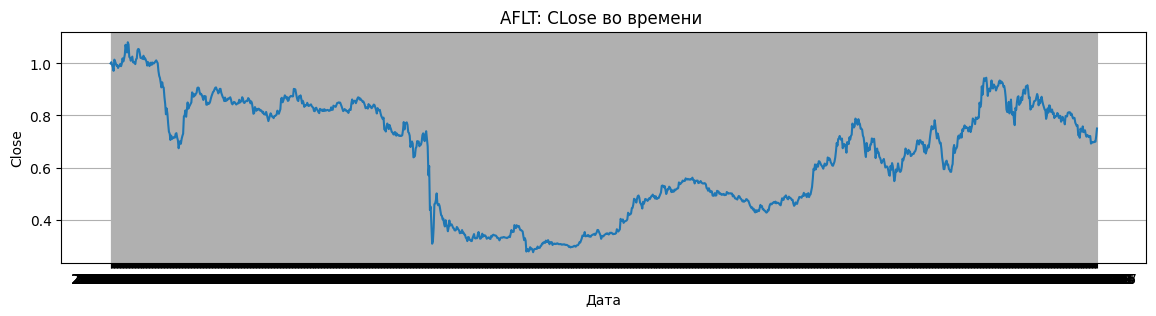

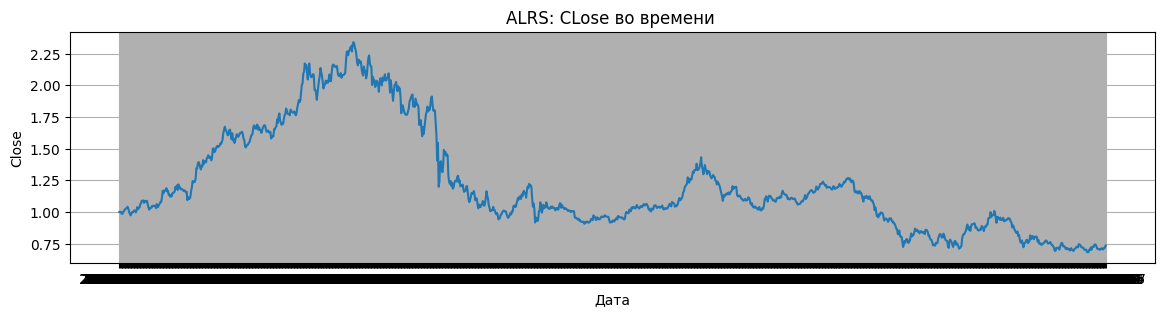

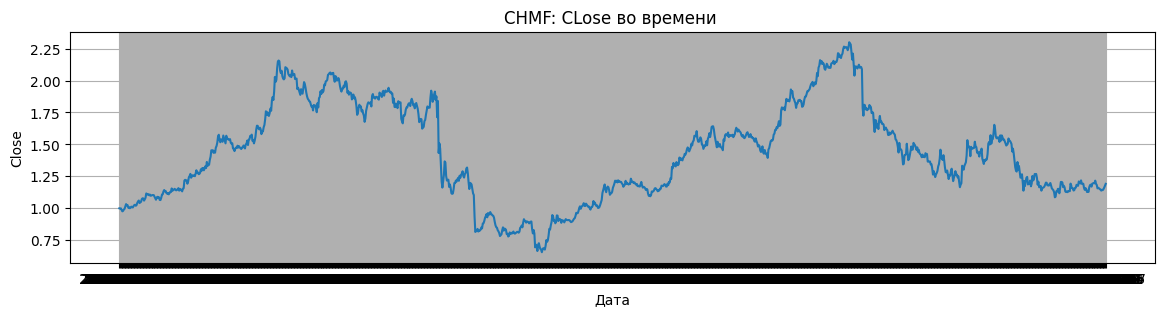

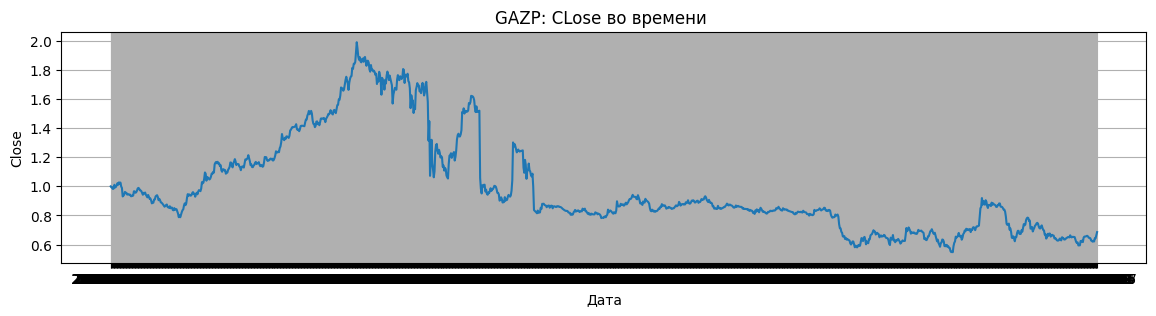

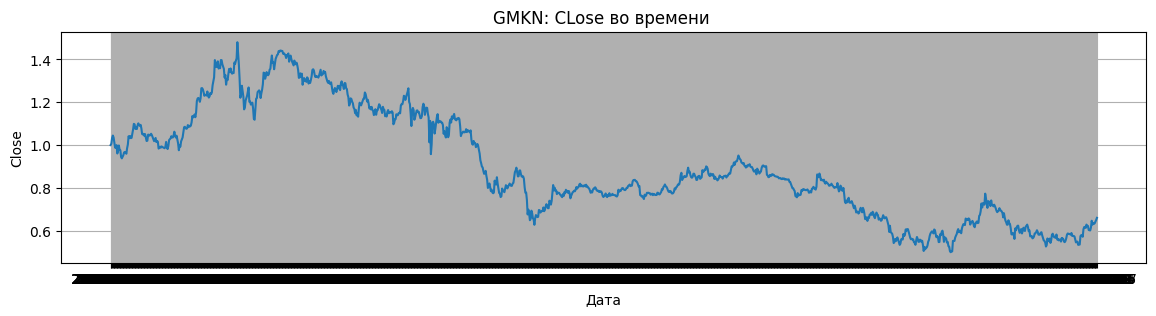

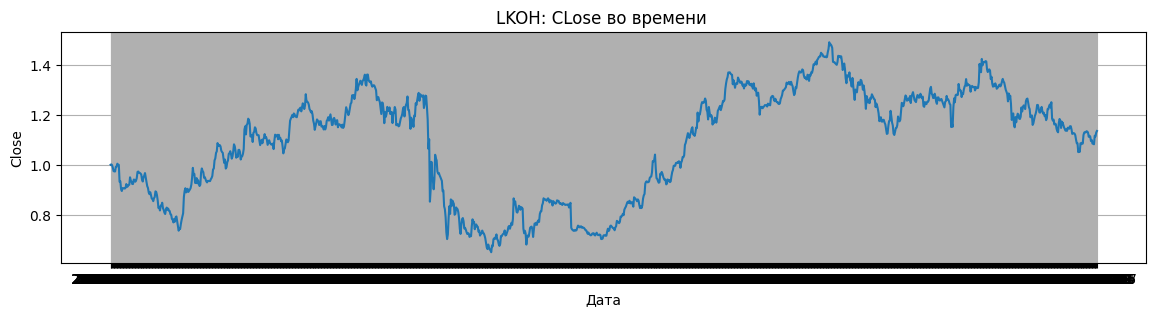

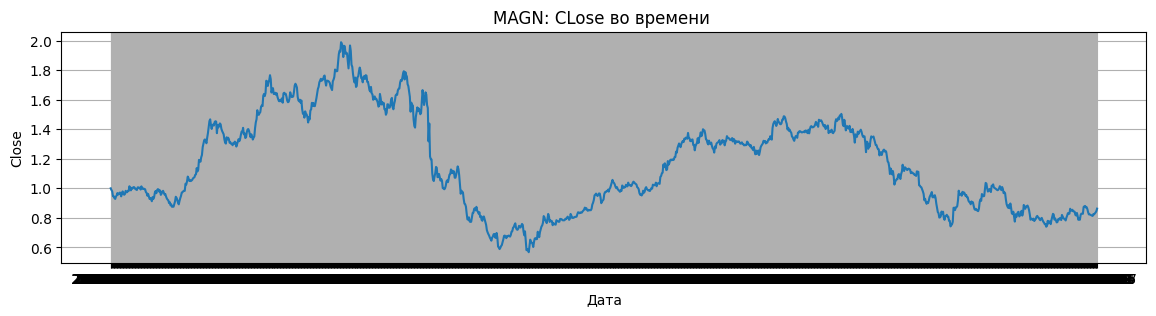

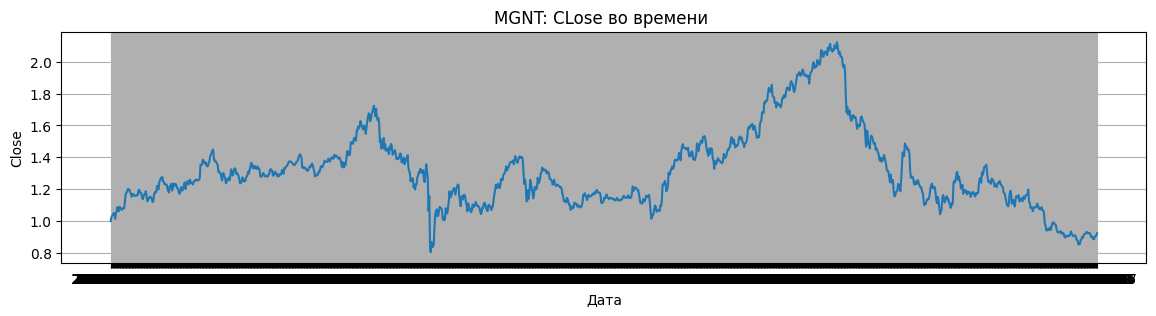

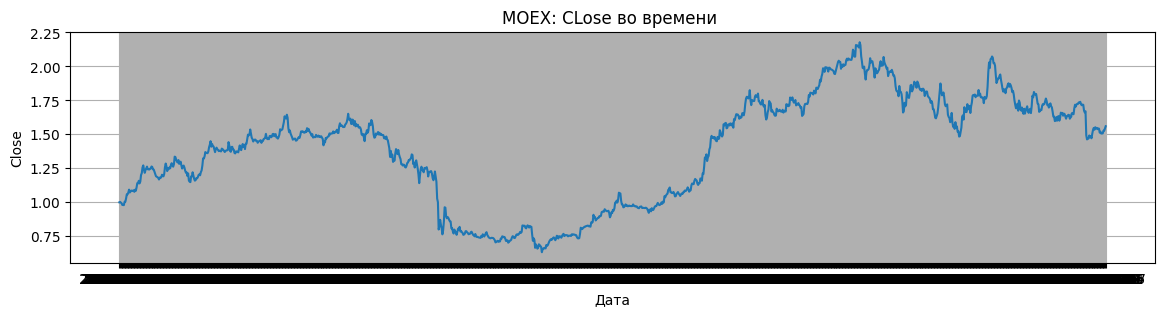

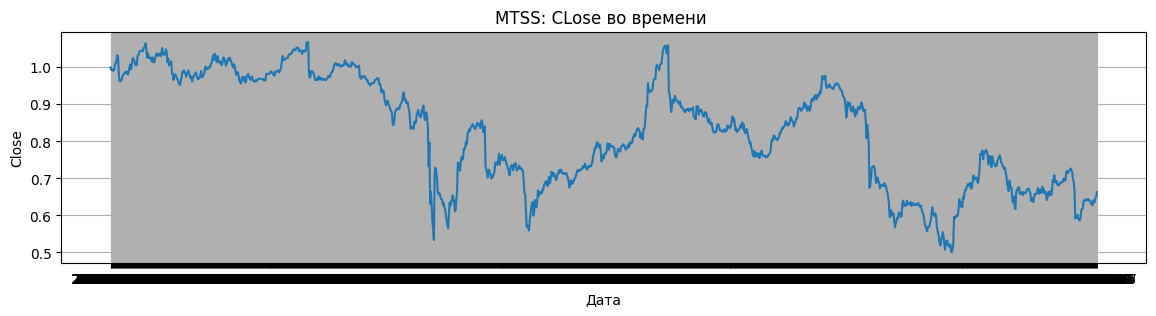

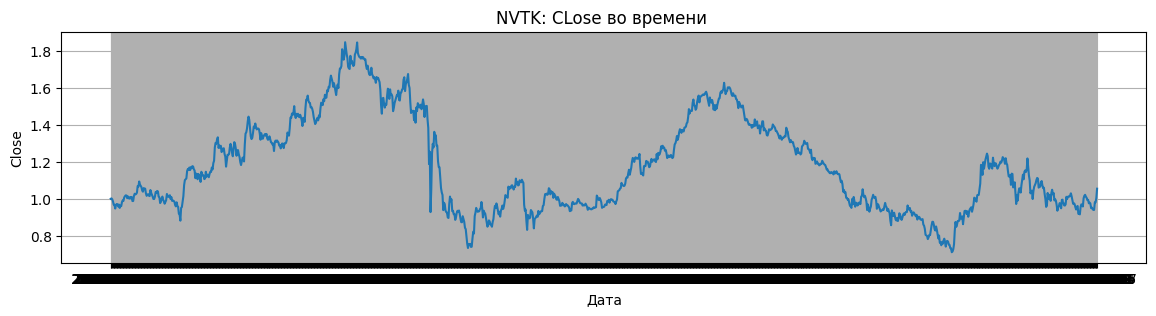

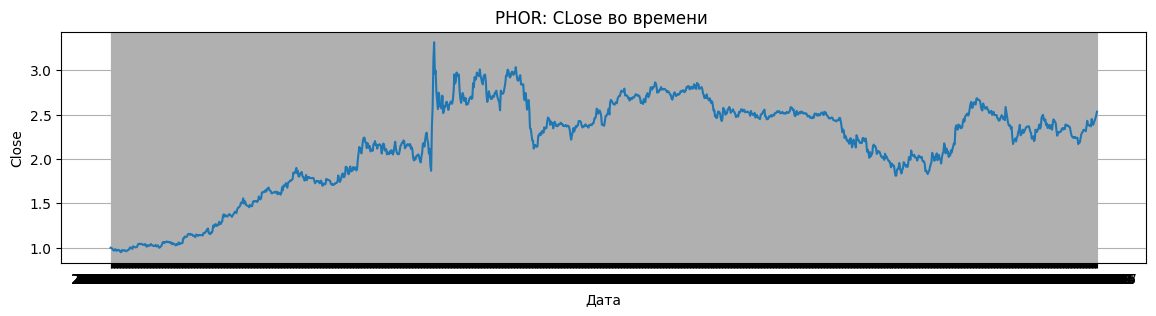

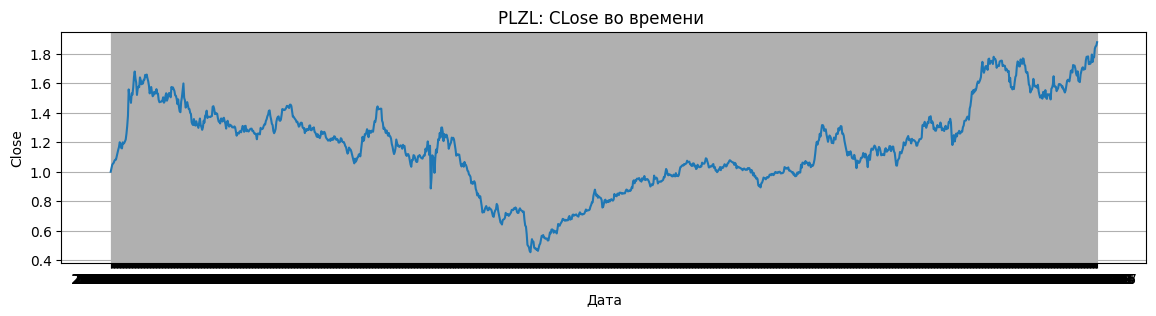

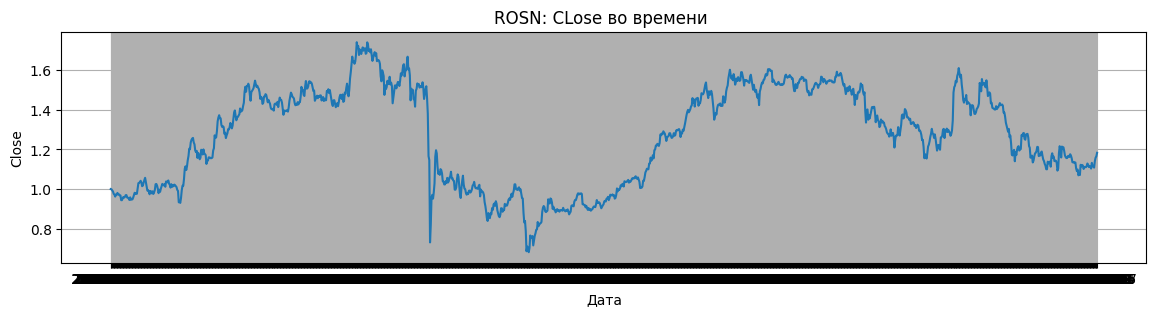

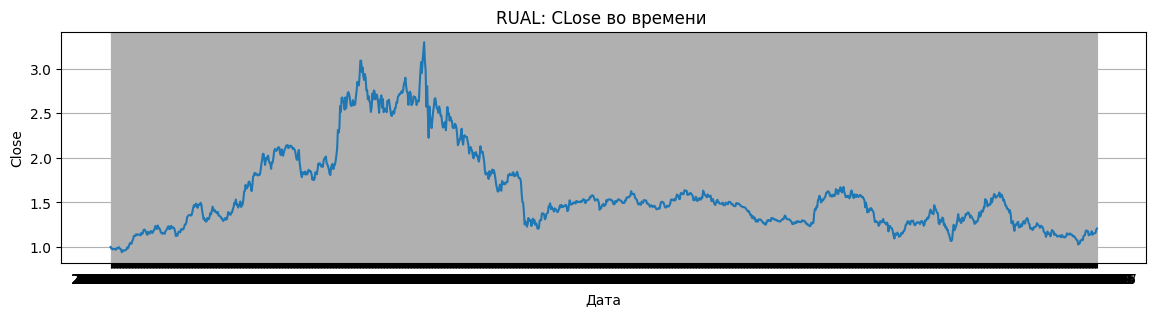

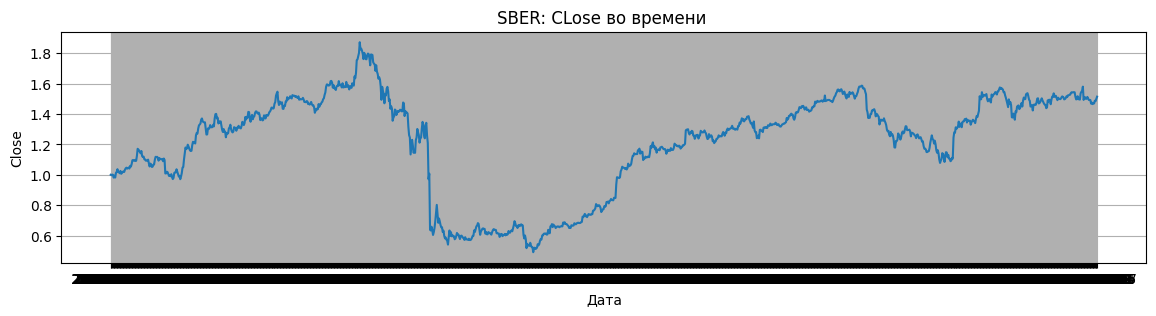

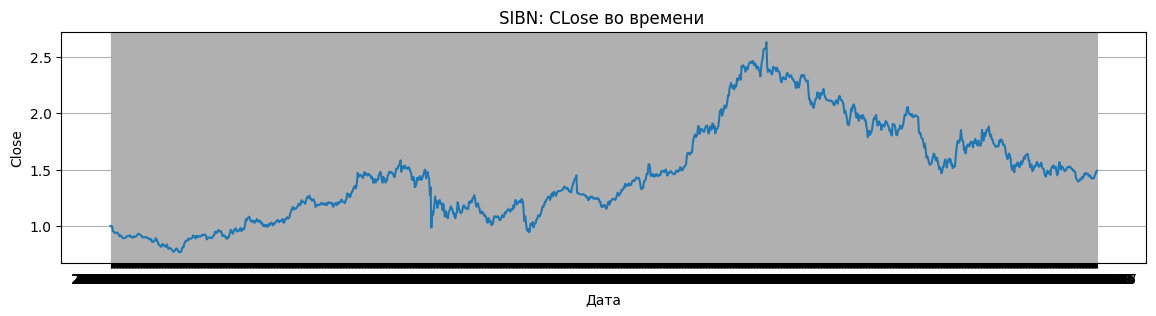

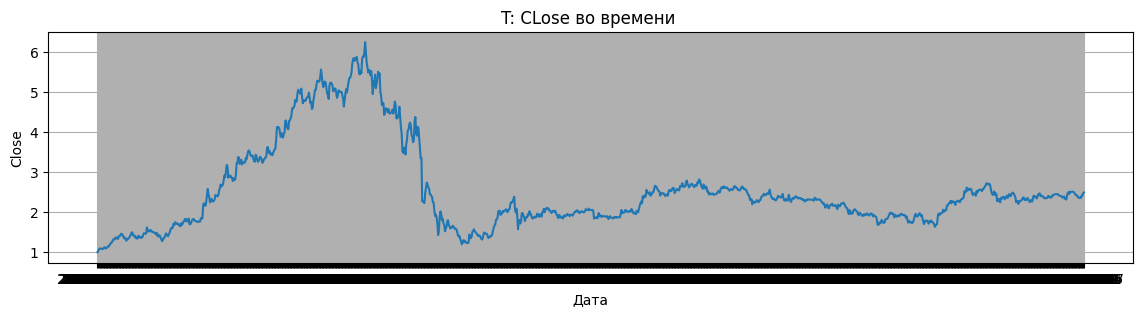

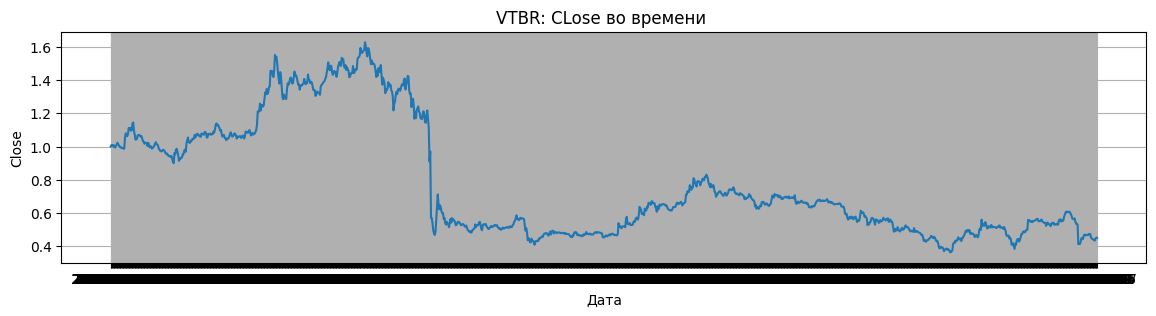

In [51]:
for ticker in df_processed['ticker'].unique():
    plt.figure(figsize=(14,3))
    df_tic = df_processed[df_processed['ticker'] == ticker].sort_values('date')
    plt.plot(df_tic['date'], df_tic['close'])
    plt.title(f'{ticker}: CLose во времени ')
    plt.xlabel("Дата")
    plt.ylabel("Close")
    plt.grid()
    plt.show()

In [52]:
df_processed['ticker'].value_counts()

ticker
AFLT    1338
ALRS    1338
CHMF    1338
GAZP    1338
LKOH    1338
MAGN    1338
MGNT    1338
MOEX    1338
ROSN    1338
SBER    1338
MTSS    1337
NVTK    1336
PLZL    1335
GMKN    1334
PHOR    1334
RUAL    1334
VTBR    1334
SIBN    1332
T       1316
Name: count, dtype: int64

Всех примерно поровну, возьмём разнообразные тикеры в train и в test
Пусть в test пойдут VTBR, LKOH, RUAL, CHMF

In [53]:
sentiment_cols = ['sentiment_score', 'sentiment_label', 'positive_prob', 'neutral_prob', 'negative_prob', 'confidence']

features = [col for col in df_processed.columns if col not in [f'target_{i}' for i in range(1, 31)] + ['date']]
targets = [f'target_{i}' for i in range(1, 31)]

test_tickers = ['VTBR', 'LKOH', 'RUAL', 'CHMF']

test_df = df_processed[df_processed['ticker'].isin(test_tickers)]  
train_df = df_processed[~df_processed['ticker'].isin(test_tickers)] 

X_train = train_df[features]
y_train = train_df[targets]

X_test = test_df[features]
y_test = test_df[targets]


0:	learn: 0.5674651	total: 89ms	remaining: 3m 42s
100:	learn: 0.0418528	total: 2.88s	remaining: 1m 8s
200:	learn: 0.0378176	total: 5.76s	remaining: 1m 5s
300:	learn: 0.0355607	total: 8.61s	remaining: 1m 2s
400:	learn: 0.0338759	total: 11.5s	remaining: 60s
500:	learn: 0.0326193	total: 14.3s	remaining: 57.1s
600:	learn: 0.0313088	total: 17.2s	remaining: 54.5s
700:	learn: 0.0303738	total: 20.2s	remaining: 51.8s
800:	learn: 0.0295743	total: 23.1s	remaining: 49s
900:	learn: 0.0288795	total: 26.1s	remaining: 46.3s
1000:	learn: 0.0282466	total: 29s	remaining: 43.5s
1100:	learn: 0.0276952	total: 32s	remaining: 40.6s
1200:	learn: 0.0270821	total: 35s	remaining: 37.8s
1300:	learn: 0.0263630	total: 37.9s	remaining: 35s
1400:	learn: 0.0258273	total: 40.9s	remaining: 32.1s
1500:	learn: 0.0252497	total: 43.8s	remaining: 29.2s
1600:	learn: 0.0248572	total: 46.9s	remaining: 26.3s
1700:	learn: 0.0244746	total: 49.8s	remaining: 23.4s
1800:	learn: 0.0240966	total: 52.7s	remaining: 20.5s
1900:	learn: 0.02

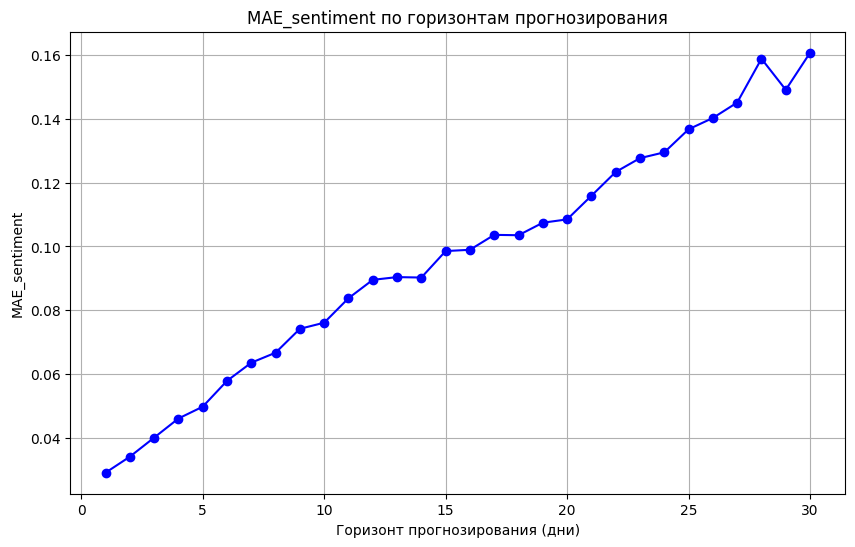

In [54]:
mae_results_sentiment = {}
models = {}
predictions = {}

for horizon in range(1, 31):
    target_col = f'target_{horizon}'
    model = CatBoostRegressor(
        iterations=2500,
        learning_rate=0.1,
        depth=10,
        loss_function='RMSE',
        random_seed=42,
        verbose=100,
        cat_features=['ticker']

    )
    model.fit(X_train, y_train[target_col])
    models[horizon] = model
    
    y_pred = model.predict(X_test)
    predictions[horizon] = y_pred
    mae = mean_absolute_error(y_test[target_col], y_pred)
    mae_results_sentiment[horizon] = mae  
    print(f"MAE_sentiment для горизонта {horizon}: {mae:.4f}")

horizons = list(mae_results_sentiment.keys())
mae_values = list(mae_results_sentiment.values())

plt.figure(figsize=(10, 6))
plt.plot(horizons, mae_values, marker='o', linestyle='-', color='b')
plt.title("MAE_sentiment по горизонтам прогнозирования")
plt.xlabel("Горизонт прогнозирования (дни)")
plt.ylabel("MAE_sentiment")
plt.grid(True)
plt.show()

Также попробуем посмотреть на разницу с обучением без анализа новостей

0:	learn: 0.5668789	total: 31.4ms	remaining: 1m 18s
100:	learn: 0.0423960	total: 2.21s	remaining: 52.5s
200:	learn: 0.0383632	total: 4.54s	remaining: 52s
300:	learn: 0.0363258	total: 6.93s	remaining: 50.6s
400:	learn: 0.0346082	total: 9.29s	remaining: 48.6s
500:	learn: 0.0333535	total: 11.6s	remaining: 46.5s
600:	learn: 0.0324410	total: 14.1s	remaining: 44.4s
700:	learn: 0.0315020	total: 16.4s	remaining: 42.1s
800:	learn: 0.0304703	total: 18.8s	remaining: 39.8s
900:	learn: 0.0297060	total: 21.1s	remaining: 37.5s
1000:	learn: 0.0290629	total: 23.6s	remaining: 35.3s
1100:	learn: 0.0285018	total: 25.9s	remaining: 32.9s
1200:	learn: 0.0279745	total: 28.3s	remaining: 30.6s
1300:	learn: 0.0274362	total: 30.7s	remaining: 28.3s
1400:	learn: 0.0268411	total: 33.1s	remaining: 25.9s
1500:	learn: 0.0263371	total: 35.4s	remaining: 23.6s
1600:	learn: 0.0258572	total: 37.8s	remaining: 21.2s
1700:	learn: 0.0254066	total: 40.1s	remaining: 18.9s
1800:	learn: 0.0249827	total: 42.6s	remaining: 16.5s
1900:

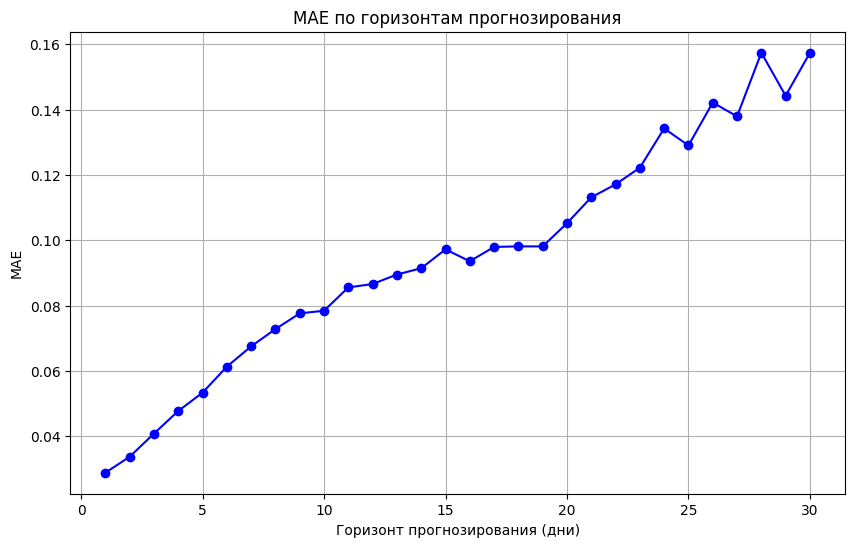

In [57]:
features = [col for col in df_processed.columns if col not in [f'target_{i}' for i in range(1, 31)] + sentiment_cols + ['date']]
targets = [f'target_{i}' for i in range(1, 31)]

features

test_tickers = ['VTBR', 'LKOH', 'RUAL', 'CHMF']

test_df = df_processed[df_processed['ticker'].isin(test_tickers)]  
train_df = df_processed[~df_processed['ticker'].isin(test_tickers)] 

X_train = train_df[features]
y_train = train_df[targets]

X_test = test_df[features]
y_test = test_df[targets]

mae_results = {}
models = {}
predictions = {}

for horizon in range(1, 31):
    target_col = f'target_{horizon}'
    model = CatBoostRegressor(
        iterations=2500,
        learning_rate=0.1,
        depth=10,
        loss_function='RMSE',
        random_seed=42,
        verbose=100,
        cat_features=['ticker']
    )
    model.fit(X_train, y_train[target_col])
    models[horizon] = model
    
    y_pred = model.predict(X_test)
    predictions[horizon] = y_pred
    mae = mean_absolute_error(y_test[target_col], y_pred)
    mae_results[horizon] = mae  
    print(f"MAE для горизонта {horizon}: {mae:.4f}")

horizons = list(mae_results.keys())
mae_values = list(mae_results.values())

plt.figure(figsize=(10, 6))
plt.plot(horizons, mae_values, marker='o', linestyle='-', color='b')
plt.title("MAE по горизонтам прогнозирования")
plt.xlabel("Горизонт прогнозирования (дни)")
plt.ylabel("MAE")
plt.grid(True)
plt.show()

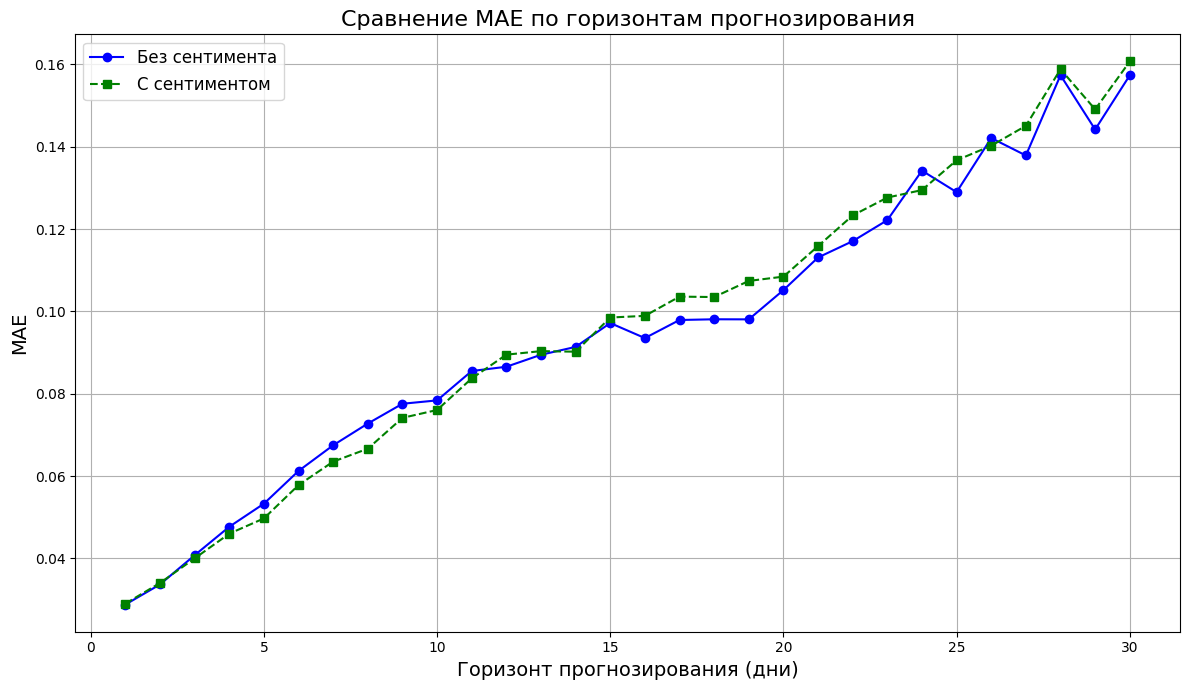

In [58]:
horizons = list(mae_results.keys())
mae_values = list(mae_results.values())
mae_values_sentiment = list(mae_results_sentiment.values())

plt.figure(figsize=(12, 7))
plt.plot(horizons, mae_values, marker='o', linestyle='-', color='blue', label='Без сентимента')
plt.plot(horizons, mae_values_sentiment, marker='s', linestyle='--', color='green', label='С сентиментом')

plt.title("Сравнение MAE по горизонтам прогнозирования", fontsize=16)
plt.xlabel("Горизонт прогнозирования (дни)", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

### Генерация фичей

In [7]:
!pip install TA-lib -q

In [9]:
import pandas as pd
import numpy as np
import talib
import warnings
from sklearn.metrics import mean_absolute_error

In [39]:
df_processed = pd.read_csv('/kaggle/input/maindata/news_analysis_complete.csv')

In [40]:
all_tickers_data = []

PATTERN_FUNCTIONS = talib.get_function_groups()['Pattern Recognition']
INDICATORS = {
    'SMA': [10, 20, 50],
    'EMA': [10, 20, 50],
    'RSI': [14],
    'MACD': [12, 26, 9],
    'ATR': [14]
}

TARGET = 'return'
for ticker, df_ticker in df_processed.groupby('ticker'):
    df_ticker = df_ticker.copy()
    for pattern_func in PATTERN_FUNCTIONS:
        try:
            indicator_func = getattr(talib, pattern_func)
            result = indicator_func(df_ticker['open'], df_ticker['high'], df_ticker['low'], df_ticker['close'])
            df_ticker[pattern_func] = result
        except Exception:
            df_ticker[pattern_func] = 0  

    for name, params in INDICATORS.items():
        if name == 'MACD':
            macd, macdsignal, macdhist = talib.MACD(
                df_ticker['close'],
                fastperiod=params[0],
                slowperiod=params[1],
                signalperiod=params[2]
            )
            df_ticker['MACD'] = macd
            df_ticker['MACD_signal'] = macdsignal
        elif name == 'ATR':
            df_ticker['ATR'] = talib.ATR(
                df_ticker['high'],
                df_ticker['low'],
                df_ticker['close'],
                timeperiod=params[0]
            )
        else:
            for period in params:
                col_name = f'{name}_{period}'
                try:
                    indicator_func = getattr(talib, name)
                    df_ticker[col_name] = indicator_func(df_ticker['close'], timeperiod=period)
                except Exception:
                    df_ticker[col_name] = 0 

    all_tickers_data.append(df_ticker)

df_full = pd.concat(all_tickers_data).sort_values(by=['ticker', 'date']).fillna(0)

In [27]:
df_full

,open,close,high,low,volume,ticker,date,sentiment_score,sentiment_label,positive_prob,...,SMA_10,SMA_20,SMA_50,EMA_10,EMA_20,EMA_50,RSI_14,MACD,MACD_signal,ATR
0,81.50,81.70,83.20,81.16,29755530,AFLT,2020-06-19,-0.753348,-1.0,0.020257,...,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,81.72,82.10,83.98,80.26,18502950,AFLT,2020-06-22,-0.808347,-1.0,0.072441,...,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,82.04,81.20,82.48,80.40,16848930,AFLT,2020-06-23,0.656769,1.0,0.716765,...,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,79.78,80.58,80.80,78.22,21559860,AFLT,2020-06-25,0.000000,0.0,0.000000,...,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,80.50,79.38,81.44,78.76,14677280,AFLT,2020-06-26,0.308057,0.0,0.319556,...,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25937,75.10,75.74,75.96,74.61,49552606,VTBR,2025-09-04,0.228645,0.0,0.312902,...,75.386,76.6615,78.5648,75.533108,76.520391,80.139412,40.847467,-1.469173,-1.559189,1.538630
25938,75.85,75.50,76.13,74.94,40701093,VTBR,2025-09-05,0.721074,1.0,0.771358,...,75.296,76.4865,78.6188,75.527088,76.423210,79.957474,39.732996,-1.377843,-1.522920,1.513727
25939,75.59,75.64,75.71,75.35,1681425,VTBR,2025-09-06,0.000000,0.0,0.000000,...,75.205,76.3245,78.6334,75.547617,76.348619,79.788161,40.748553,-1.279419,-1.474220,1.431318
25940,75.69,75.68,75.85,75.50,2186520,VTBR,2025-09-07,0.000000,0.0,0.000000,...,75.183,76.1035,78.5700,75.571687,76.284941,79.627057,41.054182,-1.184535,-1.416283,1.354081


In [41]:
price_volume_cols = ['open', 'close', 'high', 'low', 'volume']
def normalize_by_first_value(group):
    first_values = group[price_volume_cols].iloc[0]
    group[price_volume_cols] = group[price_volume_cols].div(first_values)
    return group

df_full = df_full.groupby('ticker', group_keys=False).apply(normalize_by_first_value)
df_full

/tmp/ipykernel_47/3430187145.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_full = df_full.groupby('ticker', group_keys=False).apply(normalize_by_first_value)


,open,close,high,low,volume,ticker,date,sentiment_score,sentiment_label,positive_prob,...,SMA_10,SMA_20,SMA_50,EMA_10,EMA_20,EMA_50,RSI_14,MACD,MACD_signal,ATR
0,1.000000,1.000000,1.000000,1.000000,1.000000,AFLT,2020-06-19,-0.753348,-1.0,0.020257,...,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.002699,1.004896,1.009375,0.988911,0.621832,AFLT,2020-06-22,-0.808347,-1.0,0.072441,...,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.006626,0.993880,0.991346,0.990636,0.566245,AFLT,2020-06-23,0.656769,1.0,0.716765,...,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.978896,0.986291,0.971154,0.963775,0.724566,AFLT,2020-06-25,0.000000,0.0,0.000000,...,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.987730,0.971603,0.978846,0.970429,0.493262,AFLT,2020-06-26,0.308057,0.0,0.319556,...,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25937,0.415836,0.429670,0.417937,0.423259,0.000918,VTBR,2025-09-04,0.228645,0.0,0.312902,...,75.386,76.6615,78.5648,75.533108,76.520391,80.139412,40.847467,-1.469173,-1.559189,1.538630
25938,0.419989,0.428308,0.418872,0.425131,0.000754,VTBR,2025-09-05,0.721074,1.0,0.771358,...,75.296,76.4865,78.6188,75.527088,76.423210,79.957474,39.732996,-1.377843,-1.522920,1.513727
25939,0.418549,0.429102,0.416561,0.427457,0.000031,VTBR,2025-09-06,0.000000,0.0,0.000000,...,75.205,76.3245,78.6334,75.547617,76.348619,79.788161,40.748553,-1.279419,-1.474220,1.431318
25940,0.419103,0.429329,0.417331,0.428308,0.000041,VTBR,2025-09-07,0.000000,0.0,0.000000,...,75.183,76.1035,78.5700,75.571687,76.284941,79.627057,41.054182,-1.184535,-1.416283,1.354081


In [42]:
for i in range(1, 31):
    df_full[f'target_{i}'] = df_full.groupby('ticker')['close'].shift(-i)
df_full

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,open,close,high,low,volume,ticker,date,sentiment_score,sentiment_label,positive_prob,...,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,target_30
0,1.000000,1.000000,1.000000,1.000000,1.000000,AFLT,2020-06-19,-0.753348,-1.0,0.020257,...,1.053611,1.042105,1.081518,1.072705,1.024969,1.022032,1.010282,1.018360,1.026438,1.004651
1,1.002699,1.004896,1.009375,0.988911,0.621832,AFLT,2020-06-22,-0.808347,-1.0,0.072441,...,1.042105,1.081518,1.072705,1.024969,1.022032,1.010282,1.018360,1.026438,1.004651,1.003182
2,1.006626,0.993880,0.991346,0.990636,0.566245,AFLT,2020-06-23,0.656769,1.0,0.716765,...,1.081518,1.072705,1.024969,1.022032,1.010282,1.018360,1.026438,1.004651,1.003182,1.004406
3,0.978896,0.986291,0.971154,0.963775,0.724566,AFLT,2020-06-25,0.000000,0.0,0.000000,...,1.072705,1.024969,1.022032,1.010282,1.018360,1.026438,1.004651,1.003182,1.004406,0.997307
4,0.987730,0.971603,0.978846,0.970429,0.493262,AFLT,2020-06-26,0.308057,0.0,0.319556,...,1.024969,1.022032,1.010282,1.018360,1.026438,1.004651,1.003182,1.004406,0.997307,1.015912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25937,0.415836,0.429670,0.417937,0.423259,0.000918,VTBR,2025-09-04,0.228645,0.0,0.312902,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25938,0.419989,0.428308,0.418872,0.425131,0.000754,VTBR,2025-09-05,0.721074,1.0,0.771358,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25939,0.418549,0.429102,0.416561,0.427457,0.000031,VTBR,2025-09-06,0.000000,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25940,0.419103,0.429329,0.417331,0.428308,0.000041,VTBR,2025-09-07,0.000000,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
df_full.dropna(subset=[f'target_{i}' for i in range(1, 31)], inplace=True)
df_full = df_full[df_full['EMA_50'] != 0]
df_full

,open,close,high,low,volume,ticker,date,sentiment_score,sentiment_label,positive_prob,...,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,target_30
49,1.013742,0.991677,0.996154,0.985707,0.369046,AFLT,2020-08-31,0.978377,1.0,0.983243,...,0.910894,0.907222,0.870991,0.844553,0.804651,0.826928,0.806120,0.767687,0.737576,0.730233
50,0.991902,1.005386,0.990385,0.988664,0.259532,AFLT,2020-09-01,0.965288,1.0,0.978983,...,0.907222,0.870991,0.844553,0.804651,0.826928,0.806120,0.767687,0.737576,0.730233,0.705998
51,1.006380,0.996328,0.992788,0.996550,0.170406,AFLT,2020-09-02,0.968288,1.0,0.977235,...,0.870991,0.844553,0.804651,0.826928,0.806120,0.767687,0.737576,0.730233,0.705998,0.722889
52,1.000000,0.989718,0.991587,0.995318,0.255251,AFLT,2020-09-03,0.000000,0.0,0.000000,...,0.844553,0.804651,0.826928,0.806120,0.767687,0.737576,0.730233,0.705998,0.722889,0.709670
53,0.997301,1.001224,0.989423,0.993100,0.137801,AFLT,2020-09-04,0.774854,1.0,0.786133,...,0.804651,0.826928,0.806120,0.767687,0.737576,0.730233,0.705998,0.722889,0.709670,0.712362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25907,0.431894,0.435002,0.431912,0.432619,0.001518,VTBR,2025-08-01,0.908155,1.0,0.939245,...,0.433414,0.434265,0.430577,0.426323,0.425698,0.426266,0.424280,0.419912,0.426209,0.429670
25908,0.424585,0.434662,0.423329,0.430350,0.001008,VTBR,2025-08-04,0.644043,1.0,0.714057,...,0.434265,0.430577,0.426323,0.425698,0.426266,0.424280,0.419912,0.426209,0.429670,0.428308
25909,0.425858,0.447312,0.434553,0.430918,0.002595,VTBR,2025-08-05,-0.727220,-1.0,0.058742,...,0.430577,0.426323,0.425698,0.426266,0.424280,0.419912,0.426209,0.429670,0.428308,0.429102
25910,0.437265,0.451567,0.441596,0.438009,0.002410,VTBR,2025-08-06,0.218222,0.0,0.305192,...,0.426323,0.425698,0.426266,0.424280,0.419912,0.426209,0.429670,0.428308,0.429102,0.429329


In [45]:
df_full["month"] = pd.to_datetime(df_full["date"]).dt.month
df_full["weekday"] = pd.to_datetime(df_full["date"]).dt.weekday

df_full["month_sin"] = np.sin(2 * np.pi * df_full["month"] / 12)
df_full["month_cos"] = np.cos(2 * np.pi * df_full["month"] / 12)
df_full["weekday_sin"] = np.sin(2 * np.pi * df_full["weekday"] / 7)
df_full["weekday_cos"] = np.cos(2 * np.pi * df_full["weekday"] / 7)
df_full

/tmp/ipykernel_47/1711806493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full["month"] = pd.to_datetime(df_full["date"]).dt.month
/tmp/ipykernel_47/1711806493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full["weekday"] = pd.to_datetime(df_full["date"]).dt.weekday
/tmp/ipykernel_47/1711806493.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,open,close,high,low,volume,ticker,date,sentiment_score,sentiment_label,positive_prob,...,target_27,target_28,target_29,target_30,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
49,1.013742,0.991677,0.996154,0.985707,0.369046,AFLT,2020-08-31,0.978377,1.0,0.983243,...,0.806120,0.767687,0.737576,0.730233,8,0,-0.866025,-5.000000e-01,0.000000,1.000000
50,0.991902,1.005386,0.990385,0.988664,0.259532,AFLT,2020-09-01,0.965288,1.0,0.978983,...,0.767687,0.737576,0.730233,0.705998,9,1,-1.000000,-1.836970e-16,0.781831,0.623490
51,1.006380,0.996328,0.992788,0.996550,0.170406,AFLT,2020-09-02,0.968288,1.0,0.977235,...,0.737576,0.730233,0.705998,0.722889,9,2,-1.000000,-1.836970e-16,0.974928,-0.222521
52,1.000000,0.989718,0.991587,0.995318,0.255251,AFLT,2020-09-03,0.000000,0.0,0.000000,...,0.730233,0.705998,0.722889,0.709670,9,3,-1.000000,-1.836970e-16,0.433884,-0.900969
53,0.997301,1.001224,0.989423,0.993100,0.137801,AFLT,2020-09-04,0.774854,1.0,0.786133,...,0.705998,0.722889,0.709670,0.712362,9,4,-1.000000,-1.836970e-16,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25907,0.431894,0.435002,0.431912,0.432619,0.001518,VTBR,2025-08-01,0.908155,1.0,0.939245,...,0.424280,0.419912,0.426209,0.429670,8,4,-0.866025,-5.000000e-01,-0.433884,-0.900969
25908,0.424585,0.434662,0.423329,0.430350,0.001008,VTBR,2025-08-04,0.644043,1.0,0.714057,...,0.419912,0.426209,0.429670,0.428308,8,0,-0.866025,-5.000000e-01,0.000000,1.000000
25909,0.425858,0.447312,0.434553,0.430918,0.002595,VTBR,2025-08-05,-0.727220,-1.0,0.058742,...,0.426209,0.429670,0.428308,0.429102,8,1,-0.866025,-5.000000e-01,0.781831,0.623490
25910,0.437265,0.451567,0.441596,0.438009,0.002410,VTBR,2025-08-06,0.218222,0.0,0.305192,...,0.429670,0.428308,0.429102,0.429329,8,2,-0.866025,-5.000000e-01,0.974928,-0.222521


In [46]:
df_full.describe()

,open,close,high,low,volume,sentiment_score,sentiment_label,positive_prob,negative_prob,neutral_prob,...,target_27,target_28,target_29,target_30,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
count,24441.000000,24441.000000,24441.000000,24441.000000,24441.000000,24441.000000,24441.000000,24441.000000,24441.000000,24441.000000,...,24441.000000,24441.000000,24441.000000,24441.000000,24441.000000,24441.000000,2.444100e+04,2.444100e+04,24441.000000,24441.000000
mean,1.292576,1.288179,1.294834,1.282148,2.351256,0.118421,0.116648,0.166524,0.048102,0.089781,...,1.291467,1.291588,1.291711,1.291848,6.571458,2.110143,-1.150786e-02,-2.883700e-02,0.313266,-0.071696
std,0.607450,0.607806,0.614104,0.601550,9.618916,0.373972,0.441803,0.328502,0.173360,0.221886,...,0.612480,0.612644,0.612808,0.612976,3.396418,1.519802,6.956879e-01,7.177013e-01,0.551706,0.769663
min,0.268712,0.274663,0.279808,0.264170,0.000009,-0.975367,-1.000000,0.000000,0.000000,0.000000,...,0.274663,0.274663,0.274663,0.274663,1.000000,0.000000,-1.000000e+00,-1.000000e+00,-0.974928,-0.900969
25%,0.878970,0.874000,0.879023,0.869879,0.339690,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.866463,0.866350,0.866241,0.866133,4.000000,1.000000,-5.000000e-01,-8.660254e-01,0.000000,-0.900969
50%,1.206834,1.199277,1.206738,1.197068,0.603233,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.206604,1.206858,1.207101,1.207326,7.000000,2.000000,-2.449294e-16,-1.836970e-16,0.433884,-0.222521
75%,1.525588,1.520676,1.527191,1.516247,1.156224,0.000000,0.000000,0.061598,0.005245,0.021031,...,1.525316,1.525389,1.525471,1.525574,10.000000,3.000000,5.000000e-01,5.000000e-01,0.781831,0.623490
max,6.250000,6.249064,6.285714,6.020608,282.920141,0.993264,1.000000,0.994640,0.978652,0.981615,...,6.249064,6.249064,6.249064,6.249064,12.000000,6.000000,1.000000e+00,1.000000e+00,0.974928,1.000000


In [48]:
df_full.to_csv('itog_dataset.csv', index=False)

In [ ]:
df = pd.read_csv('/kaggle/input/maindata/news_analysis_complete.csv')
